### Installation

In [1]:
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")
# BiocManager::install("chromVAR", version = "3.8")
# BiocManager::install("motifmatchr", version = "3.8")
# BiocManager::install("BSgenome.Mmusculus.UCSC.mm9", version = "3.8")
# BiocManager::install("JASPAR2016", version = "3.8")

###  Import packages

In [2]:
library(chromVAR)
library(motifmatchr)
library(Matrix)
library(SummarizedExperiment)
library(BiocParallel)
library('JASPAR2016')
library(BSgenome.Mmusculus.UCSC.mm9)


Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:Matrix’:

    colMeans, colSums, rowMeans, rowSums, which

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, r

In [3]:
packageVersion("chromVAR")

[1] ‘1.4.1’

In [4]:
register(MulticoreParam(10))

### Obtain Feature Matrix

In [5]:
start_time <- Sys.time()

In [6]:
set.seed(2019)

In [7]:
metadata <- read.table('../../input/metadata.tsv',
                         header = TRUE,
                         stringsAsFactors=FALSE,quote="",row.names=1)

In [8]:
head(metadata)

label     
TCCGCGAACTAACTAGGTTGCTACGGTCATAGAGGC BoneMarrow
TCCGCGAAAGGTCAGCTTTGCGGATAGTGTACTGAC BoneMarrow
ATTACTCGTTGCCGTAGGCTTAATCTTGTATAGCCT BoneMarrow
TCCGCGAAACCAGGCGCAAAGCTAGGTTGTACTGAC BoneMarrow
ATTCAGAATCGTAGCATCGCGCAATGACCCTATCCT BoneMarrow
ATTCAGAAATGGCGCCTGTGCGGATAGTAGGCGAAG BoneMarrow

In [9]:
peakfile <- "../../input/combined.sorted.merged.bed"
peaks <- getPeaks(peakfile, sort_peaks = TRUE)

Warning message in getPeaks(peakfile, sort_peaks = TRUE):
“Peaks are not equal width!Use resize(peaks, width = x, fix = "center") to make peaks equal in size, where x is the desired size of the peaks)”Peaks sorted


`width=500` will cause the error: Error in loadFUN(x, seqname, ranges): trying to load regions beyond the boundaries of non-circular sequence "chr17"

In [10]:
peaks <- resize(peaks, width = 450, fix = "center")

In [11]:
bamfile <- list.files(path = "../../input/sc-bams_nodup/", pattern = "\\.bam$")

In [12]:
length(bamfile)

[1] 12178

In [13]:
head(bamfile)

[1] "BoneMarrow_62016.AGCGATAGAATACGATAATGGCAGCTCGCAGGACGT.header.bam"
[2] "BoneMarrow_62016.AGCGATAGAATATTACTTTCCGCGGACTGTACTGAC.header.bam"
[3] "BoneMarrow_62016.AGCGATAGACCAGGCGCATGGCAGCTCGATAGAGGC.header.bam"
[4] "BoneMarrow_62016.AGCGATAGAGATTACGTTGCGCAATGACGTACTGAC.header.bam"
[5] "BoneMarrow_62016.AGCGATAGAGGTCAGCTTGGAGTTGCGTGTACTGAC.header.bam"
[6] "BoneMarrow_62016.AGCGATAGAGTTGAATCAAAGCTAGGTTCCTATCCT.header.bam"

In [14]:
cellnames <- sapply(strsplit(bamfile,'.',fixed = TRUE), "[[", 2)

In [15]:
sum(cellnames == rownames(metadata))

[1] 20

In [16]:
ix = match(rownames(metadata),cellnames)
bamfile = bamfile[ix]
cellnames = cellnames[ix]

In [17]:
sum(cellnames == rownames(metadata))

[1] 12178

In [18]:
head(paste0("../../input/sc-bams_nodup/",bamfile))

[1] "../../input/sc-bams_nodup/BoneMarrow_62016.TCCGCGAACTAACTAGGTTGCTACGGTCATAGAGGC.header.bam"
[2] "../../input/sc-bams_nodup/BoneMarrow_62016.TCCGCGAAAGGTCAGCTTTGCGGATAGTGTACTGAC.header.bam"
[3] "../../input/sc-bams_nodup/BoneMarrow_62016.ATTACTCGTTGCCGTAGGCTTAATCTTGTATAGCCT.header.bam"
[4] "../../input/sc-bams_nodup/BoneMarrow_62016.TCCGCGAAACCAGGCGCAAAGCTAGGTTGTACTGAC.header.bam"
[5] "../../input/sc-bams_nodup/BoneMarrow_62016.ATTCAGAATCGTAGCATCGCGCAATGACCCTATCCT.header.bam"
[6] "../../input/sc-bams_nodup/BoneMarrow_62016.ATTCAGAAATGGCGCCTGTGCGGATAGTAGGCGAAG.header.bam"

In [ ]:
fragment_counts <- getCounts(paste0("../../input/sc-bams_nodup/",bamfile), 
                             peaks, 
                             paired = TRUE, 
                             by_rg = FALSE, 
                             format = "bam", 
                             colData = data.frame(cellid = cellnames,
                                                  label = metadata$label))

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCCGCGAACTAACTAGGTTGCTACGGTCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCCGCGAAAGGTCAGCTTTGCGGATAGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.ATTACTCGTTGCCGTAGGCTTAATCTTGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCCGCGAAACCAGGCGCAAAGCTAGGTTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.ATTCAGAATCGTAGCATCGCGCAATGACCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.ATTCAGAAATGGCGCCTGTGCGGATAGTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAATTCGTTCCGGCTTATCTTAATCTTGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.AGCGATAGCCGCTAAGAGTCCGCGGACTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAATTCGTAGGTCAGCTTTCCGCGGACTCAGGACGT.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CTGAAGCTAATACGATAATGCGGATAGTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TAATGCGCCCGTATGATTTGGCAGCTCGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TAATGCGCCTAGCCAGCCTGGCAGCTCGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CTGAAGCTAGAGGAGAATAAGCTAGGTTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CGCTCATTATTATGCAAGTCCGCGGACTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CGGCTATGATGGAACGAACTTAATCTTGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCCGCGAACGCGGCCATAAAGCTAGGTTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.ATTACTCGTCTTGAGGTTTCCGCGGACTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCTCGCGCCTAACTAGGTAAGCTAGGTTCCTATCCT.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.AGCGATAGTTCCGTCGACTGGCAGCTCGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.AGCGATAGAGATTACGTTGCGCAATGACGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.ATTCAGAAATTGGCAGATAAGCTAGGTTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAGATTCCCTAATTGCGATCCGCGGACTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCTCGCGCAATACGATAAGGAGTTGCGTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.ATTACTCGCTCAATTAGTTGGCAGCTCGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAGATTCCTTGATTGGCGAAGCTAGGTTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAGATTCCTGATTAGGTAGCGCAATGACAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CTGAAGCTCCGTATGATTGGAGTTGCGTGGCTCTGA.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAATTCGTCTAACTAGGTTGCGGATAGTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CGCTCATTATGGCGCCTGTGCTACGGTCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CGCTCATTTTCCGTCGACTGCTACGGTCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAATTCGTTCGCCGCCGGTGCGGATAGTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCCGGAGACGCGGCCATATGGCAGCTCGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCTCGCGCCTAATTGCGAGCGCAATGACGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CTGAAGCTCTAATTGCGATGCGGATAGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TAATGCGCATGGAACGAATCCGCGGACTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CTGAAGCTCTCAATTAGTTGGCAGCTCGCAGGACGT.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCTCGCGCCGCGGCCATAGCGCAATGACCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAGATTCCAGTTGAATCATCCGCGGACTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.ATTACTCGAATACGATAAAAGCTAGGTTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAGATTCCAACGCGCAGATGCGGATAGTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCTCGCGCTCTTGAGGTTAAGCTAGGTTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCCGCGAATATAATAGTTAAGCTAGGTTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCCGCGAAAGAGGAGAATTGCGGATAGTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAGATTCCTAGTAAGCCGGCGCAATGACCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CTGAAGCTACCAGGCGCATGGCAGCTCGTATAGCCT.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCTCGCGCCTCAATTAGTTGGCAGCTCGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.AGCGATAGGCATATGAGCAAGCTAGGTTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CGCTCATTGCGTTCCGTTTGCTACGGTCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAGATTCCATGGAACGAATCCGCGGACTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCCGGAGATGATTAGGTAGCGCAATGACGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CTGAAGCTGCTAACGGATTGCGGATAGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAATTCGTATAAGGACTCGGAGTTGCGTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAGATTCCTCTTGAGGTTGGAGTTGCGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.ATTCAGAAGCGGCTGCGGGGAGTTGCGTCCTATCCT.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAATTCGTATGGCGCCTGTGCTACGGTCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CGCTCATTAATATTACTTTGGCAGCTCGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAGATTCCACCAGGCGCATCCGCGGACTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAATTCGTGCATATGAGCAAGCTAGGTTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAGATTCCAGTTGAATCACTTAATCTTGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCTCGCGCAATACGATAAGGAGTTGCGTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAGATTCCCTCGTCGTAGCTTAATCTTGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCCGCGAAGTACTCCTATGGAGTTGCGTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.GAGATTCCTTGCCGTAGGGGAGTTGCGTATAGAGGC.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CTGAAGCTCTAGCCAGCCTGGCAGCTCGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.ATTACTCGGCGGCTGCGGTCCGCGGACTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CGCTCATTCTAGCCAGCCCTTAATCTTGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TAATGCGCAGTTGAATCATGCGGATAGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.ATTACTCGCATAGCGACCGGAGTTGCGTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.CGCTCATTGTACTCCTATAAGCTAGGTTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCCGGAGATGATTAGGTATGGCAGCTCGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.TCTCGCGCTTGATTGGCGTGGCAGCTCGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62016.ATTACTCGATTGGCAGATTGCTACGGTCGTACTGAC.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCCGGAGAAACGCGCAGAGATTAGATGACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.AGCGATAGGTACTCCTATTTCAGCTTGGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCCGCGAAAGGTCAGCTTCTTATAAGTTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTACTCGTGCGACCTCTAGCTTATAGGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CGCTCATTAACGCGCAGAGATTAGATGACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCCGGAGACTAACTAGGTTATAGGATCTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.AGCGATAGAGGTCAGCTTTATAGGATCTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TAATGCGCGAACTCGACTATTGCGGCCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTCAGAAATAAGGACTCTATAGGATCTGTACTGAC.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.GAGATTCCTTGGCAAGCCGATTAGATGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTCAGAAAGACCATATCATTGCGGCCAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.AGCGATAGCCGTATGATTCCATCTGGCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCCGGAGACGCGGCCATATGGCGTAGAAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTACTCGTCGCCGCCGGGATTAGATGAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.GAATTCGTCCGTATGATTCCATCTGGCACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.AGCGATAGCTAATTGCGACTTATAAGTTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCCGCGAAATTGGCAGATCTTATAAGTTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.AGCGATAGTCGCCGCCGGTATAGGATCTAGGCGAAG.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CGGCTATGTTGATTGGCGCCATCTGGCAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CTGAAGCTCGCGGCCATAATTGCGGCCACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TAATGCGCTGATTAGGTAAGCTTATAGGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CTGAAGCTCCGCTAAGAGCCATCTGGCAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCTCGCGCATAAGGACTCAGCTTATAGGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTCAGAATATTAGACTTCCATCTGGCAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCTCGCGCCTAGCCAGCCTATAGGATCTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TAATGCGCAATATTACTTTTCAGCTTGGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TAATGCGCAGTTGAATCAGATTAGATGACCTATCCT.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.GAATTCGTAACGCGCAGATTCAGCTTGGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CTGAAGCTGCGGCTGCGGTTCAGCTTGGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.AGCGATAGATTGGCAGATATTGCGGCCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CTGAAGCTGGTTATCGAAAGCTTATAGGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTCAGAAGCTAACGGATCTTATAAGTTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CGGCTATGAATATTACTTGATTAGATGATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTCAGAAAATATTACTTGATTAGATGACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.GAGATTCCCATAGCGACCATTGCGGCCATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCTCGCGCCATAGCGACCATTGCGGCCAAGGCGAAG.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.GAGATTCCCCGTATGATTATTGCGGCCAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.AGCGATAGTCTTGAGGTTATTGCGGCCAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TAATGCGCCTAGCCAGCCTATAGGATCTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CGCTCATTTATTAGACTTTTCAGCTTGGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CTGAAGCTAGAGGAGAATAGCTTATAGGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.GAGATTCCATGGAACGAATATAGGATCTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CGGCTATGTATTAGACTTTATAGGATCTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CGGCTATGCTAGCCAGCCTTCAGCTTGGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TAATGCGCTGCGACCTCTATTGCGGCCAATAGAGGC.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTACTCGAGAGGAGAATGATTAGATGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.GAATTCGTTTGATTGGCGTATAGGATCTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTACTCGAATACGATAAGATTAGATGACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CGCTCATTAATATTACTTTTCAGCTTGGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCCGGAGACTCGTCGTAGAGCTTATAGGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CGGCTATGTTCCGTCGACTTCAGCTTGGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TAATGCGCTCGGATTCGGTGGCGTAGAAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TAATGCGCAGGTCAGCTTCCATCTGGCATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCTCGCGCCCGTATGATTCTTATAAGTTGTACTGAC.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTACTCGCCGTATGATTTTCAGCTTGGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTCAGAACTAATTGCGAAGCTTATAGGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCCGGAGATTGATTGGCGCTTATAAGTTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CGGCTATGCTAACTAGGTAGCTTATAGGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CTGAAGCTTTGATTGGCGATTGCGGCCAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CTGAAGCTAACGCGCAGAATTGCGGCCAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CGGCTATGCGCGGCCATATGGCGTAGAAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCCGGAGATTGATACGATGATTAGATGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.AGCGATAGGCATCGTATGAGCTTATAGGTAATCTTA.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TAATGCGCTATTAGACTTATTGCGGCCAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTCAGAACGCGGCCATAATTGCGGCCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CGGCTATGGCATATGAGCGATTAGATGACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTCAGAAAGATTACGTTCCATCTGGCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTACTCGAGACCATATCAGCTTATAGGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.GAGATTCCGCGTTCCGTTCCATCTGGCAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.GAATTCGTTCGTAGCATCATTGCGGCCAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CTGAAGCTTCGCCGCCGGTTCAGCTTGGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.AGCGATAGAGAGGAGAATCTTATAAGTTTAATCTTA.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCTCGCGCTTGGTAAGGACCATCTGGCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCTCGCGCGCATCGTATGTTCAGCTTGGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.GAATTCGTCTCGTCGTAGGATTAGATGATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.AGCGATAGTTCCGTCGACGATTAGATGAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.CGCTCATTTATTAGACTTCCATCTGGCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCCGGAGATATTAGACTTTGGCGTAGAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.TCTCGCGCAATACGATAATTCAGCTTGGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.GAGATTCCAACGCGCAGATTCAGCTTGGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/BoneMarrow_62216.ATTACTCGCCGTATGATTGATTAGATGAGGCTCTGA.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.ATTCAGAATATTAGACTTGGTACGTTAATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.GAATTCGTTATTAGACTTTCAATATCGACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TCCGCGAACTAACTAGGTGTAGACCTGGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CGCTCATTATGGCGCCTGTTATGACCAAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TCCGGAGAAGATTACGTTTTGGTCCGTTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CGGCTATGTCGTAGCATCCCATCGTTCCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TAATGCGCTTGATACGATTCAATATCGACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.GAGATTCCTCTTGAGGTTGATGCAGTTCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TAATGCGCTAGTAAGCCGTTATGACCAATATAGCCT.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TCCGCGAATCGCCGCCGGTTGGTCCGTTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TAATGCGCAGACCATATCTTATGACCAAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CGGCTATGTCGCCGCCGGGGTACGTTAATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CGGCTATGCGCGGCCATACCATCGTTCCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TCTCGCGCCCGTATGATTCAATGAGTCCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.GAATTCGTAGATTACGTTGTAGACCTGGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CGGCTATGGCGGCTGCGGTCAATATCGAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CGCTCATTAGTTGAATCATCAATATCGAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CGCTCATTAATACGATAATCAATATCGAGGCTCTGA.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TCTCGCGCAGAGGAGAATGTAGACCTGGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TCCGGAGAGTACTCCTATCCATCGTTCCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CGCTCATTTCGGATTCGGTTATGACCAAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.GAGATTCCCTAACTAGGTGTAGACCTGGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TAATGCGCTCGTAGCATCTTATGACCAATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CGCTCATTTCGGATTCGGTCAATATCGAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.ATTCAGAAGCATATGAGCTCAATATCGAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TAATGCGCGCATATGAGCTTATGACCAACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TCTCGCGCGCATCGTATGCAATGAGTCCGGCTCTGA.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CGGCTATGGCATCGTATGGTAGACCTGGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.AGCGATAGTCGCCGCCGGGGTACGTTAAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CGGCTATGTTGGTAAGGACAATGAGTCCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TCCGCGAATTGATTGGCGCCATCGTTCCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.GAGATTCCCCGCTAAGAGGGTACGTTAACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.ATTACTCGAATACGATAATTATGACCAAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CTGAAGCTGCTAACGGATCCATCGTTCCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CTGAAGCTATGGCGCCTGTTATGACCAAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CGGCTATGAGACCATATCTCAATATCGAGGCTCTGA.header.bam
Reading in file: ../../input

Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.ATTACTCGTCGCCGCCGGGTAGACCTGGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.TCCGGAGACTAACTAGGTTTGGTCCGTTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.GAATTCGTCTAATTGCGAGTAGACCTGGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.ATTCAGAAAGTTGAATCATTGGTCCGTTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CTGAAGCTATGGAACGAAGGTACGTTAAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.CGCTCATTTCCGGCTTATCCATCGTTCCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Cerebellum_62216.GAGATTCCTATAATAGTTTTATGACCAAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTCAGAATGATTAGGTATAGTTCTAGACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGCCAGATACGGCTTAGGTATCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCCTAGCCAGCCGGAGGCGGCGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TAATGCGCAAGTAGCTCATGCCAGTTGCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CTGAAGCTTTGGTAAGGATAGTTCTAGAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGTTATTGAGGCCTTAGGTATCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTACTCGTGATTAGGTATAGTTCTAGACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TAATGCGCTCGCCGCCGGAGATCTTGGTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGGAGACTAACTAGGTTAGTTCTAGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTACTCGAAGTAGCTCAGTTGGATCTTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCTCGCGCAGAGGAGAATCCAGTACTTGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATT

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCCCAGATACGGGTTGGATCTTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGCGAAAGTCCGCTGCGTTGGATCTTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CTGAAGCTCGCTTATCGTTGCCAGTTGCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCTCGCGCTGATTAGGTAGGTCTCGCCGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCCCAGATACGGGCGATTGCAGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGTTCCGTCGACGGTCTCGCCGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTACTCGCGCTTATCGTGAGACCTACCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCTTGCCGTAGGTAGTTCTAGAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAATTCGTTCTTAGCCTGGCGATTGCAGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCC

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCCTCGTCGTAGTAGTTCTAGAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCTTGATACGATTAGTTCTAGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCAACGAATTCGGTCTGCAATCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGGAGAGCGGCTGCGGGGAGGCGGCGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TAATGCGCTCGCCGCCGGGGAGGCGGCGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTCATAGCGACCGGCGGAGGTCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CTGAAGCTTCGTAGCATCAGATCTTGGTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGCGAAATTATGCAAGGTAATGATCGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTACTCGATTATGCAAGTTGGAGTTAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAATTCGT

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGGCTATGGCGTTCCGTTCCAGTACTTGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCTGCGACCTCTGTAATGATCGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCTCGCGCTCGGATTCGGTTGGAGTTAGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTATGGCGCCTGGGAGGCGGCGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCTGATTAGGTAGTAATGATCGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTACTCGAATATTACTTAGATCTTGGTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGGAGAAGTTGAATCAGTAATGATCGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCTCGCGCTATAATAGTTAGATCTTGGTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTCTAATTGCGAGTAATGATCGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATT

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGCGAACCAGATACGGGCGATTGCAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TAATGCGCTCGCCGCCGGTTGGAGTTAGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTAACGAATTCGGTTGGATCTTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAATTCGTCTAATTGCGATTGGAGTTAGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGATGGAACGAACCAGTACTTGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCTCGCGCGAACTCGACTTAGTTCTAGAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGGAGAGCTAACGGATGGAGGCGGCGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGGAGACTAATTGCGAGTAATGATCGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCGAACTCGACTCCAGTACTTGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CTGAAGCT

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTAATATTACTTTTGGAGTTAGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TAATGCGCTTATTGAGGCGCGATTGCAGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGGAGACTCAATTAGTTTGGAGTTAGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGCGAAAACGCGCAGAGGCGGAGGTCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTCAGAATCGTAGCATCAGATCTTGGTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTCAGAACTAACTAGGTTAGTTCTAGACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCTCGCGCATTGGCAGATGTAATGATCGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCTTGATACGATCCAGTACTTGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TAATGCGCCTAATTGCGAGGTCTCGCCGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGGCTATG

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGGAACTCGACTGGAGGCGGCGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTCTAACTAGGTGGAGGCGGCGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGGATCTTCGCAGTTGGATCTTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTCAGAATTGGTAAGGAGTAATGATCGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGATAAGGACTCGGAGGCGGCGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCTCGCGCTTGATTGGCGTTGGAGTTAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAATTCGTGGTTATCGAATTGGAGTTAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGGCTATGTTGATTGGCGTTGGAGTTAGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCTCGCGCAATACGATAACCAGTACTTGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAATTCGT

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTTTCCGTCGACCCAGTACTTGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGGCTATGCCAGATACGGATTGACCGAGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCCCGTATGATTGTAATGATCGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CTGAAGCTAGGTCAGCTTTTGGAGTTAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAATTCGTATAAGGACTCTAGTTCTAGAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TAATGCGCTATTGCTGGACTTAGGTATCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGGCTATGATTATGCAAGTTGGAGTTAGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAATTCGTGCTTGAAGAGTGCCAGTTGCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CTGAAGCTTATTGCTGGAGTTGGATCTTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CTGAAGCT

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGGCTATGAGATTACGTTGGAGGCGGCGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTAGATTACGTTGGAGGCGGCGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGGCTATGAACGAATTCGGAGACCTACCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAATTCGTTATTGCTGGATGCCAGTTGCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGGCGGCTGCGGCCAGTACTTGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAATTCGTGCATCGTATGTTGGAGTTAGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTCAGAATTGCGAGCATGAGACCTACCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAATTCGTCCGTATGATTCCAGTACTTGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGGTACTCCTATGGTCTCGCCGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAG

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGCGAATGCGACCTCTGGTCTCGCCGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCTCGCGCCTAACTAGGTGGCGGAGGTCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTTCTTGAGGTTTAGTTCTAGAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAATTCGTGCGGCTGCGGGGCGGAGGTCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGATAAGGACTCTTGGAGTTAGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CTGAAGCTCGCTTATCGTTGCCAGTTGCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTACTCGCTCAATTAGTGGAGGCGGCGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TAATGCGCGATCTTCGCAGCGATTGCAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TAATGCGCACCAGGCGCATTGGAGTTAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGCGAA

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTTCTTAGCCTGGCGATTGCAGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTTTGATTGGCGGTAATGATCGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCTCGCGCTTCCGTCGACGTAATGATCGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCTCGCCGCCGGTTGGAGTTAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TAATGCGCAGGTCAGCTTGGTCTCGCCGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGGAGACCGCTAAGAGGGAGGCGGCGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGGAGAATTATGCAAGGTAATGATCGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGCGAAGAACTCGACTGGAGGCGGCGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGCGAATCTTAGCCTGGCGATTGCAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCC

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGCGAAGTACTCCTATAGATCTTGGTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTGGTTATCGAAGGAGGCGGCGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTCAGAAGCTAACGGATGGAGGCGGCGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTACTCGGCATCGTATGGGAGGCGGCGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTTATTAGACTTGGCGGAGGTCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CTGAAGCTAGACCATATCGGCGGAGGTCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CTGAAGCTCTAACTAGGTGTAATGATCGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCCGGTTATCGAATTGGAGTTAGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGGAGAAATATTACTTGGTCTCGCCGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAGATTCC

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGCGAATTGCCGTAGGAGATCTTGGTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTAACGCGCAGAAGATCTTGGTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGTCCGGCTTATCCAGTACTTGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGAGGTCAGCTTAGATCTTGGTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGGAGACCAGATACGGGTCTGCAATCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGTGATTAGGTATAGTTCTAGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGGAGAGCTAACGGATTAGTTCTAGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAATTCGTCTCAATTAGTTAGTTCTAGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CTGAAGCTTCGTAGCATCGGTCTCGCCGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCTCGCGC

Reading in file: ../../input/sc-bams_nodup/HeartA_62816.AGCGATAGTCGTAGCATCAGATCTTGGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TAATGCGCTTGATACGATCCAGTACTTGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TAATGCGCAGATTACGTTTAGTTCTAGAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TAATGCGCGCTAACGGATGGAGGCGGCGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGCTCATTTTGGTAAGGAGTAATGATCGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.GAATTCGTCGCGGCCATAAGATCTTGGTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCCGCGAAAAGTACGCGACTTAGGTATCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.TCTCGCGCAAGTAGCTCAATTGACCGAGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.CGGCTATGTCTTGAGGTTGGAGGCGGCGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/HeartA_62816.ATTACTCG

Reading in file: ../../input/sc-bams_nodup/Kidney_62016.AGCGATAGATTGGCAGATTTGGTAGTCGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCTCGCGCGCGTTCCGTTCTCCATCGAGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGCTATAATAGTTATGACTGATCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAATTCGTTTCCGTCGACTTGGTAGTCGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGGCTATGAGTTGAATCACTCCATCGAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAATGATTAGGTAATGACTGATCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCTCGCGCATTGGCAGATTTGGTAGTCGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTACTCGTGATTAGGTAATGACTGATCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTAACGCGCAGACGTTCTATCAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAA

Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCTAGTAAGCCGCGTTCTATCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCAATACGATAAATGACTGATCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCCTCGTCGTAGCTCCATCGAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCCGGAGACTCGTCGTAGGGCCGTCAACGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGCTCATTATTGGCAGATTCGTTAGAGCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTTCGCCGCCGGCGTTCTATCAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGGCTATGCTAGCCAGCCGGCCGTCAACGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGCATGGCGCCTGCGTTCTATCAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTACTCGAACGCGCAGAATGACTGATCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCC

Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCCCGTATGATTCCTAGACGAGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCTCGTAGCATCCTCCATCGAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAACCGCTAAGAGGGCCGTCAACATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAACCGCTAAGAGTTGGTAGTCGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGCTCATTATAAGGACTCTCGTTAGAGCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.AGCGATAGATTGGCAGATCTCCATCGAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTTTGGCAAGCCCTCCATCGAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAATTCGTGCGTTCCGTTCGTTCTATCAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAAAGTTGAATCACGTTCTATCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCCGGAGA

Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCGCGGCTGCGGCGGAATCTAAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAATTCGTTATAATAGTTCGTTCTATCAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGCTCATTATTATGCAAGATGACTGATCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGCAATATTACTTCGTTCTATCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGCTCATTATTATGCAAGCTCCATCGAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAAGCTAACGGATATGACTGATCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAATTCGTCATAGCGACCCGTTCTATCAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCCGCGAAAATATTACTTTTGGTAGTCGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGCTCATTTTGATACGATTTGGTAGTCGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGCTCATT

Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAATTCGTGCTAACGGATGGCCGTCAACCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCGCGTTCCGTTGGCCGTCAACGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTACTCGAATATTACTTCGTTCTATCACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAATTCCGTCGACGGCCGTCAACAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGCTCGGATTCGGATGACTGATCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGCTGCGACCTCTCTCCATCGAGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTTCTTGAGGTTCTCCATCGAGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCCGGAGAAACGCGCAGATCGTTAGAGCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCCGCGAAATTGGCAGATCTCCATCGAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.AGCGATAG

Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTAGTTGAATCATTGGTAGTCGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGCTCATTATGGCGCCTGCCTAGACGAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGGCTATGTCCGGCTTATCTCCATCGAGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAATTGATACGATCGGAATCTAATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTACTCGGGTTATCGAACCTAGACGAGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGGCTATGTCGCCGCCGGCGTTCTATCAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTCCGTATGATTTCGTTAGAGCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAATTCGTTTGCCGTAGGCTCCATCGAGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCCGGAGACTAGCCAGCCTTGGTAGTCGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAA

Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAATTCGTTAGTAAGCCGCCTAGACGAGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCTCGCGCTATTAGACTTTCGTTAGAGCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTTCGCCGCCGGATGACTGATCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTCATAGCGACCCGTTCTATCATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGCAACGCGCAGACCTAGACGAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTTAGTAAGCCGATGACTGATCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAATAGTAAGCCGCCTAGACGAGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCCGGAGAAACGCGCAGATCGTTAGAGCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCAACGCGCAGACCTAGACGAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGGCTATG

Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCCTAACTAGGTCCTAGACGAGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGCGTACTCCTATCGGAATCTAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTTGATTAGGTACGGAATCTAAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAATTCGTTGCGACCTCTCCTAGACGAGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAAGCTAACGGATCCTAGACGAGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTCTCAATTAGTCTCCATCGAGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCCGGAGATTGGCAAGCCGGCCGTCAACGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAATTCGTTTGATACGATATGACTGATCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCTCGCGCAGAGGAGAATCCTAGACGAGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCCGCGAA

Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGCAGATTACGTTATGACTGATCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCTCCGGCTTATGGCCGTCAACTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCAGATTACGTTCGTTCTATCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.AGCGATAGCATAGCGACCTCGTTAGAGCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCTATAATAGTTCGGAATCTAAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTACTCGAATATTACTTTCGTTAGAGCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGCTCGCCGCCGGTTGGTAGTCGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCTCGCGCTATAATAGTTTCGTTAGAGCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTCTCAATTAGTCGGAATCTAAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGGCTATG

Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGCAATATTACTTCCTAGACGAGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAATTCGTCTCGTCGTAGATGACTGATCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.AGCGATAGGCGTTCCGTTCGTTCTATCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAATTCGTGCATCGTATGGGCCGTCAACATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCTTCCGTCGACCGGAATCTAAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAATTCGTGGTTATCGAAATGACTGATCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGGCTATGATTGGCAGATTCGTTAGAGCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAATATAATAGTTCCTAGACGAGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCCGCGAACCGCTAAGAGTCGTTAGAGCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGC

Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGGCTATGGTACTCCTATCCTAGACGAGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAAGGTTATCGAAATGACTGATCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.AGCGATAGATTCTTAGCTCGTTCTATCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCGCGGCTGCGGCGGAATCTAATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCTCGCGCTCGCCGCCGGCCTAGACGAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGCAGACCATATCCGGAATCTAAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCCGGAGAATAAGGACTCCGTTCTATCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGCTCATTATGGAACGAACCTAGACGAGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGCTCATTAATACGATAACCTAGACGAGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTACTCG

Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGGCTATGTATTAGACTTTTGGTAGTCGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TCCGGAGAGCATATGAGCCGTTCTATCAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.GAGATTCCGTACTCCTATCTCCATCGAGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTTGCGACCTCTCGGAATCTAATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGCTCATTCTCGTCGTAGATGACTGATCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CTGAAGCTGCGTTCCGTTCGGAATCTAAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGCGCATATGAGCCTCCATCGAGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.ATTCAGAAAATATTACTTGGCCGTCAACCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.TAATGCGCGGTTATCGAACGTTCTATCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Kidney_62016.CGCTCATT

Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.TCTCGCGCTCCGGCTTATTTGGTCCGTTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CTGAAGCTTTGGTAAGGATTATGACCAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.AGCGATAGCATAGCGACCGTAGACCTGGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.TCTCGCGCATTGGCAGATCAATGAGTCCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CGCTCATTTTGGCAAGCCTTATGACCAAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.GAGATTCCGCATCGTATGTTATGACCAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.AGCGATAGGCTAACGGATTCAATATCGAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CGGCTATGTGCGACCTCTTTGGTCCGTTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.TCCGCGAATCGGATTCGGGGTACGTTAATAA

Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.GAATTCGTTTGGCAAGCCCAATGAGTCCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.ATTCAGAAGCATATGAGCGTAGACCTGGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CTGAAGCTTTGGTAAGGATTATGACCAAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.AGCGATAGAATACGATAAGTAGACCTGGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.AGCGATAGTTGGCAAGCCTCAATATCGAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.ATTCAGAATGCGACCTCTTCAATATCGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CGGCTATGAGATTACGTTCAATGAGTCCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CGCTCATTATTCTTAGCTTCAATATCGAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.AGCGATAGGTACTCCTATCAATGAGTCCCAG

Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CGGCTATGTCCGGCTTATGTAGACCTGGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.AGCGATAGAACGCGCAGATTATGACCAACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.AGCGATAGGCGTTCCGTTTTGGTCCGTTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.ATTACTCGCTAGCCAGCCTTGGTCCGTTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.TCCGGAGAAGACCATATCTCAATATCGAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CGGCTATGTCTTGAGGTTGGTACGTTAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CGCTCATTGTACTCCTATGATGCAGTTCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.ATTCAGAAGAACTCGACTGTAGACCTGGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CGGCTATGAGATTACGTTCCATCGTTCCCAG

Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.AGCGATAGGCGTTCCGTTGGTACGTTAAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.ATTACTCGAGGTCAGCTTTTATGACCAACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CGGCTATGTCGTAGCATCTTATGACCAAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.AGCGATAGGCTAACGGATGTAGACCTGGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.AGCGATAGGAACTCGACTCCATCGTTCCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CTGAAGCTAATATTACTTCCATCGTTCCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.AGCGATAGTTGGTAAGGAGATGCAGTTCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CTGAAGCTCATAGCGACCCAATGAGTCCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CTGAAGCTATTGGCAGATTCAATATCGACAG

Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.TAATGCGCCCGTATGATTGTAGACCTGGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.AGCGATAGGCGGCTGCGGGTAGACCTGGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.ATTACTCGTGCGACCTCTGGTACGTTAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.ATTCAGAAAGTTGAATCACAATGAGTCCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CGCTCATTCATAGCGACCCAATGAGTCCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.ATTACTCGAATATTACTTCAATGAGTCCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.CTGAAGCTTGATTAGGTACAATGAGTCCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.ATTACTCGTCCGGCTTATGTAGACCTGGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineA_62816.GAGATTCCTCGTAGCATCTTATGACCAAGTA

Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CTGAAGCTCGCTTATCGTAGGACGGACGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.AGCGATAGCGCTTATCGTGGAAGTTATAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TAATGCGCTCAATCTCCTTGGTAATCCTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.ATTACTCGCGTTACCGCTGGAAGTTATACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TCCGGAGATCTTAGCCTGGTCGGTAGTTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CTGAAGCTTTGCGAGCATGGAAGTTATACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.GAATTCGTCGTTACCGCTTGGTAATCCTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TAATGCGCAACGAATTCGAGGTCCTCGTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.GAGATTCCCGTCGAGCGCAGGTCCTCGTGTA

Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.AGCGATAGAAGTAGCTCACTCCTGGACCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.ATTCAGAACTACTAATAATAGCCTCGTTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CTGAAGCTAAGTAGCTCATAGCCTCGTTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TCTCGCGCCGCTTATCGTGTCGGTAGTTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CGCTCATTTAGGTAACTTGGTTGAACGTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.ATTACTCGTATTGCTGGATGGTAATCCTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TCCGCGAATTGCTTAGATAGGACGGACGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.GAGATTCCTTATTGAGGCTGGTAATCCTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.GAGATTCCTAAGTCCTGAAGGACGGACGCAG

Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CTGAAGCTCCAGATACGGCTCCTGGACCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CGCTCATTGCTTGAAGAGCTCCTGGACCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TAATGCGCGCGCGTTCATGGTTGAACGTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TAATGCGCCATTATTATTGTCGGTAGTTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.ATTACTCGCGCTTATCGTTAGCCTCGTTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TCCGCGAAATACCTCGACTGGTAATCCTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TCTCGCGCGATCTTCGCAGTCGGTAGTTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.ATTCAGAACCAGATACGGTAGCCTCGTTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TAATGCGCCGAATGGAGCCTCCTGGACCGTA

Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TAATGCGCCCAGATACGGTAGCCTCGTTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TAATGCGCCATTATTATTTAGCCTCGTTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CTGAAGCTCATTATTATTGGTTGAACGTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.AGCGATAGGGCTTACTCCAGGTCCTCGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CTGAAGCTACGGCGTTAATGGTAATCCTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CTGAAGCTATACCTCGACGGTTGAACGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.ATTACTCGCTATATAGCCTAGCCTCGTTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CGGCTATGTAGGTAACTTAGGACGGACGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TAATGCGCCTATATAGCCTAGCCTCGTTTAT

Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.ATTACTCGGTAGCAGCTAGGTTGAACGTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.GAGATTCCAGCCGTAGTTGTCGGTAGTTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CGCTCATTGCAAGACCGTTGGTAATCCTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.ATTCAGAACAGCTAGCGGGGAAGTTATAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CGGCTATGACTATTCATTAGGACGGACGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CGGCTATGCTAAGCCTTGTAGCCTCGTTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TCTCGCGCCGTTACCGCTTAGCCTCGTTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TAATGCGCAACGAATTCGCTCCTGGACCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TCCGGAGAAGCCGTAGTTCTCCTGGACCATA

Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CGCTCATTTGGACGACTAGGTTGAACGTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.AGCGATAGCAGCTAGCGGTGGTAATCCTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.ATTCAGAACAGCTAGCGGGTCGGTAGTTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.GAGATTCCCAGACTAAGGCTCCTGGACCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TAATGCGCCTAAGCCTTGTGGTAATCCTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CGGCTATGAGCCGTAGTTGTCGGTAGTTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.ATTCAGAAAACGAATTCGAGGTCCTCGTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TAATGCGCTTGCTTAGATTAGCCTCGTTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.GAGATTCCATACCTCGACCTCCTGGACCTAA

Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TCTCGCGCCGAATGGAGCGGAAGTTATACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TAATGCGCTCAATCTCCTCTCCTGGACCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.GAGATTCCCGAATGGAGCTAGCCTCGTTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CGGCTATGCTAAGCCTTGAGGACGGACGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TCCGCGAATAAGTCCTGAGGTTGAACGTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.GAGATTCCAACGAATTCGCTCCTGGACCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TCCGGAGACGAATGGAGCCTCCTGGACCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.AGCGATAGACGGCGTTAAGGAAGTTATACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.ATTACTCGAACGAATTCGGGAAGTTATAAGG

Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.AGCGATAGGATTCTTGAACTCCTGGACCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.GAGATTCCCGTTACCGCTGGAAGTTATACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TCCGGAGAGTAGGATAAGGGAAGTTATATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CGGCTATGGCAAGACCGTAGGTCCTCGTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CGGCTATGCAGCTAGCGGGGTTGAACGTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TAATGCGCGACTGGACCACTCCTGGACCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.ATTACTCGAACGAATTCGCTCCTGGACCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CTGAAGCTAGCCGTAGTTAGGTCCTCGTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.GAGATTCCCTACTAATAATGGTAATCCTTAT

Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.ATTCAGAATTCGAATATTAGGTCCTCGTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TCCGGAGATTCGAATATTGGAAGTTATAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CGCTCATTAGTTCTCATGGGTTGAACGTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TCCGCGAACTATATAGCCGGTTGAACGTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TCCGGAGACTACTAATAAAGGTCCTCGTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TCCGGAGACGCTTATCGTCTCCTGGACCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CGGCTATGCGTCGAGCGCGTCGGTAGTTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.AGCGATAGACTATTCATTGTCGGTAGTTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CTGAAGCTCGCTTATCGTTGGTAATCCTTAA

Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.AGCGATAGGATCTTCGCAAGGTCCTCGTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CTGAAGCTAAGTAGCTCATGGTAATCCTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.TAATGCGCGACTGGACCATAGCCTCGTTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.GAATTCGTCGTCGAGCGCAGGACGGACGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.GAATTCGTTAGGTAACTTCTCCTGGACCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.GAGATTCCATACCTCGACGTCGGTAGTTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.CGGCTATGGCAAGACCGTGTCGGTAGTTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.GAGATTCCACTATTCATTTGGTAATCCTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/LargeIntestineB_62816.GAGATTCCTCTTAGCCTGCTCCTGGACCCCT

Reading in file: ../../input/sc-bams_nodup/Liver_62016.TAATGCGCGAACTCGACTAGAACCGGAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.CGCTCATTTCGTAGCATCTCGTAACGGTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.ATTCAGAAAATACGATAAATTCGGAAGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCTCGCGCATGGCGCCTGGAGATGCATGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.AGCGATAGTATAATAGTTATTCGGAAGTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.CGGCTATGAGTTGAATCAAGTCATAGCCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.GAATTCGTTAGTAAGCCGGTCAAGTCCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.CGCTCATTATTATGCAAGTGGCGACGGAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGGAGAATTCTTAGCTAGAACCGGAGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.GAATTCGTTCCGGCTTAT

Reading in file: ../../input/sc-bams_nodup/Liver_62016.TAATGCGCCTAATTGCGAATTCGGAAGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGGAGATATTAGACTTATTCGGAAGTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.GAATTCGTGCTAACGGATAGTCATAGCCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.AGCGATAGTCGCCGCCGGGATTACCGGAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.GAATTCGTGCTAACGGATGAGATGCATGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.CGCTCATTCCGTATGATTATTCGGAAGTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TAATGCGCATTGGCAGATGAGATGCATGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGGAGAATGGAACGAAAGAACCGGAGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCTCGCGCGTACTCCTATGTCAAGTCCAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.ATTCAGAATTGATACGAT

Reading in file: ../../input/sc-bams_nodup/Liver_62016.GAGATTCCAGAGGAGAATGATTACCGGATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGGAGACTAACTAGGTGATTACCGGACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGGAGAGAACTCGACTTGGCGACGGATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGCGAATTGGTAAGGAAGTCATAGCCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.GAGATTCCCCGTATGATTAGAACCGGAGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.CTGAAGCTTCCGGCTTATAGAACCGGAGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.GAATTCGTTGCGACCTCTAGAACCGGAGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.AGCGATAGAATACGATAAATTCGGAAGTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.ATTCAGAATTGATACGATAGTCATAGCCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.CGCTCATTCTAATTGCGA

Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCTCGCGCTTCCGTCGACGATTACCGGATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGGAGATAGTAAGCCGGAGATGCATGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCTCGCGCAGGTCAGCTTGATTACCGGAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.CTGAAGCTCTAGCCAGCCGTCAAGTCCACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.AGCGATAGTTGGCAAGCCAGTCATAGCCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.CTGAAGCTGAACTCGACTTCGTAACGGTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.CGCTCATTTTCCGTCGACATTCGGAAGTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCTCGCGCAACGCGCAGATCGTAACGGTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCTCGCGCATTGGCAGATATTCGGAAGTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.CGGCTATGAGGTCAGCTT

Reading in file: ../../input/sc-bams_nodup/Liver_62016.ATTCAGAAAGATTACGTTAGAACCGGAGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.AGCGATAGGCATATGAGCAGAACCGGAGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGCGAACTAATTGCGAGTCAAGTCCAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.ATTACTCGTGCGACCTCTAGAACCGGAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.CTGAAGCTATTCTTAGCTAGAACCGGAGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.CGCTCATTGCGGCTGCGGAGTCATAGCCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.CGGCTATGCTCGTCGTAGTGGCGACGGAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.CGCTCATTCTCAATTAGTAGAACCGGAGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.GAGATTCCGCATATGAGCTGGCGACGGAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGCGAAATTCTTAGCT

Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGCGAATGATTAGGTAGATTACCGGAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.GAGATTCCTCCGGCTTATTGGCGACGGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGGAGAAGTTGAATCAGATTACCGGAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.CGCTCATTTTGATTGGCGAGAACCGGAGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.AGCGATAGCTAGCCAGCCTCGTAACGGTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGGAGACTCGTCGTAGAGTCATAGCCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGGAGACCGCTAAGAGAGAACCGGAGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCTCGCGCTAGTAAGCCGTCGTAACGGTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGGAGATGCGACCTCTTCGTAACGGTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGGAGACATAGCGACC

Reading in file: ../../input/sc-bams_nodup/Liver_62016.ATTCAGAATTGGCAAGCCTCGTAACGGTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.CGGCTATGATGGAACGAAATTCGGAAGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.GAGATTCCGCATATGAGCGTCAAGTCCAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.CGGCTATGGCGGCTGCGGATTCGGAAGTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGCGAAACCAGGCGCAGTCAAGTCCAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.CGGCTATGTTGATACGATAGTCATAGCCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.ATTACTCGTTGGCAAGCCGTCAAGTCCAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.CGCTCATTTATAATAGTTGATTACCGGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCTCGCGCCGCGGCCATAATTCGGAAGTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCTCGCGCTAGTAAGCCG

Reading in file: ../../input/sc-bams_nodup/Liver_62016.TAATGCGCTCGTAGCATCAGTCATAGCCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.AGCGATAGAGTTGAATCAATTCGGAAGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGGAGAAATACGATAAGAGATGCATGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCTCGCGCATGGAACGAAGTCAAGTCCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.ATTCAGAATGCGACCTCTAGAACCGGAGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.GAGATTCCACCAGGCGCAGAGATGCATGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGCGAATTCCGTCGACTGGCGACGGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.ATTCAGAAATTATGCAAGGATTACCGGAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGGAGAAATATTACTTAGTCATAGCCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TAATGCGCAGACCATATC

Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGCGAACCGCTAAGAGATTCGGAAGTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCTCGCGCGCATATGAGCAGTCATAGCCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.ATTACTCGCCGTATGATTAGAACCGGAGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.ATTACTCGAGGTCAGCTTGATTACCGGAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.ATTACTCGTTGCCGTAGGTCGTAACGGTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.GAGATTCCTTGCCGTAGGGAGATGCATGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.CGGCTATGCTCGTCGTAGAGTCATAGCCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TAATGCGCGTACTCCTATAGAACCGGAGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.ATTACTCGCTAGCCAGCCTGGCGACGGATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.GAGATTCCTTGATTGGCG

Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCTCGCGCATGGAACGAATCGTAACGGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.CTGAAGCTCTAGCCAGCCATTCGGAAGTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.ATTACTCGGCGTTCCGTTTCGTAACGGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TAATGCGCATGGAACGAAGTCAAGTCCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TAATGCGCAGTTGAATCAGAGATGCATGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.GAATTCGTTTCCGTCGACATTCGGAAGTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.CGGCTATGCTAACTAGGTATTCGGAAGTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.ATTCAGAAATTGGCAGATGAGATGCATGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.CGGCTATGGGTTATCGAAAGTCATAGCCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGCGAACGCGGCCATA

Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGCGAACTAACTAGGTTCGTAACGGTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGCGAAGGTTATCGAATCGTAACGGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGCGAAAGACCATATCTCGTAACGGTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.CGGCTATGCTCAATTAGTAGAACCGGAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGCGAAAATACGATAAGATTACCGGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.ATTCAGAATCGTAGCATCAGTCATAGCCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGCGAAAGTTGAATCATCGTAACGGTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.GAGATTCCATGGAACGAAAGAACCGGAGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCTCGCGCCTAATTGCGAGAGATGCATGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Liver_62016.TCCGCGAACGCGGCCATA

Reading in file: ../../input/sc-bams_nodup/Lung1_62216.CTGAAGCTTCTTAGCCTGTAGACTAGTCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCCGCGAAACTATTCATTAGATGCAACTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCCGGAGACGCTTATCGTTCGTCGGAACGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCTCGCGCGATCTTCGCAAGATGCAACTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.CGCTCATTAGCCGTAGTTTAGACTAGTCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.CTGAAGCTCGCTTATCGTGTCGAAGCAGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.ATTACTCGCTATATAGCCGTAGGCAATTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCTCGCGCTAAGTCCTGAAGGCGCTAGGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.ATTCAGAATAAGTCCTGAGTAGGCAATTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCCGGAGATCTATCGCTG

Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TAATGCGCTCTATCGCTGATCGAGATGATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.ATTCAGAACGTTACCGCTGTCGAAGCAGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.CTGAAGCTCCAGATACGGATCGAGATGACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TAATGCGCTCAATCTCCTGTAGGCAATTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TAATGCGCGATCTTCGCAGTAGGCAATTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.CGGCTATGCATTATTATTGTCGAAGCAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.CGGCTATGAACGAATTCGAAGCCTACGAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.CGGCTATGACTATTCATTTCGTCGGAACAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCCGGAGACTATATAGCCTCGTCGGAACTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.GAGATTCCTCAATCTCCT

Reading in file: ../../input/sc-bams_nodup/Lung1_62216.ATTCAGAATCTTAGCCTGAGGCGCTAGGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCCGCGAATAGGTAACTTAGGCGCTAGGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.CGGCTATGAGTCCGCTGCAGATGCAACTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCCGCGAAAACGAATTCGTCGTCGGAACTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.CTGAAGCTTCCTCTGCCGAGATGCAACTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.CGGCTATGTAAGTCCTGAAAGCCTACGAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCTCGCGCCTATATAGCCATCGAGATGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.CTGAAGCTACGGCGTTAAGTCGAAGCAGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCCGCGAACAGCTAGCGGTCGTCGGAACAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.CTGAAGCTAACGAATTCG

Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCCGGAGACAGCTAGCGGGTAGGCAATTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.GAGATTCCCATTATTATTAAGCCTACGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCCGGAGATATTGCTGGAAGGCGCTAGGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.GAGATTCCCGCTTATCGTGTAGGCAATTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.GAGATTCCCTACTAATAAGTCGAAGCAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCCGCGAAGGCTTACTCCAGATGCAACTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.ATTACTCGTCAATCTCCTATCGAGATGATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCCGGAGATTCGAATATTGTAGGCAATTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.CGCTCATTCAGACTAAGGAGGCGCTAGGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCCGCGAATCAATCTCCT

Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TAATGCGCACTATTCATTAGGCGCTAGGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.CTGAAGCTAGTTCTCATGATCGAGATGATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.GAGATTCCGCAAGACCGTAAGCCTACGATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCTCGCGCTAGGTAACTTGTAGGCAATTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCTCGCGCGCAAGACCGTTCGTCGGAACTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCCGGAGAGGCTTACTCCAGATGCAACTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.CGCTCATTTAAGTCCTGATCGTCGGAACGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.ATTACTCGTTCGAATATTAGGCGCTAGGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.ATTCAGAAAACGAATTCGTCGTCGGAACAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCCGGAGATTGCGAGCAT

Reading in file: ../../input/sc-bams_nodup/Lung1_62216.ATTCAGAACTACTAATAAGTAGGCAATTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.ATTCAGAAGTAGCAGCTAGTCGAAGCAGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TAATGCGCGCGCTATGGTTAGACTAGTCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.GAGATTCCCCAGATACGGTAGACTAGTCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.CGCTCATTCCAGATACGGGTAGGCAATTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCTCGCGCCTAAGCCTTGGTCGAAGCAGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCTCGCGCCTACTAATAAATCGAGATGAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.GAGATTCCTCTATCGCTGAGATGCAACTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.CTGAAGCTGTAGCAGCTAAGGCGCTAGGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.CTGAAGCTACGGCGTTAA

Reading in file: ../../input/sc-bams_nodup/Lung1_62216.GAATTCGTTAGAGGCGTTGTCGAAGCAGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.ATTCAGAATCTTAGCCTGAAGCCTACGATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.GAGATTCCCTATATAGCCTCGTCGGAACCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.ATTCAGAACGTCGAGCGCATCGAGATGAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCCGGAGATGGACGACTAAGATGCAACTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.CTGAAGCTTAGGTAACTTATCGAGATGACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.GAGATTCCTTGCTTAGATGTAGGCAATTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.GAGATTCCTCCTCTGCCGTAGACTAGTCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.CGGCTATGTCTTAGCCTGGTCGAAGCAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCCGGAGAGATTCTTGAA

Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TAATGCGCTCTTAGCCTGAGGCGCTAGGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.AGCGATAGGGCTTACTCCTAGACTAGTCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.GAATTCGTTAGGTAACTTGTCGAAGCAGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCCGCGAAGCGCTATGGTGTCGAAGCAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.ATTACTCGAGTTCTCATGAGGCGCTAGGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.CGCTCATTTTGCGAGCATTAGACTAGTCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.ATTCAGAACCAGATACGGAAGCCTACGAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCCGCGAACAGCTAGCGGAGATGCAACTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TAATGCGCCGAATGGAGCAGATGCAACTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCTCGCGCAAGTACGCGA

Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCCGCGAAGACTGGACCAAAGCCTACGATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCCGCGAATGGACGACTAAGGCGCTAGGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCCGCGAATATTGCTGGATCGTCGGAACTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TAATGCGCCAGCTAGCGGAAGCCTACGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.ATTACTCGTGGTTGCCGTAAGCCTACGAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.GAATTCGTTGGTTGCCGTTCGTCGGAACAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.CGCTCATTGATCTTCGCAATCGAGATGACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.GAATTCGTCAGACTAAGGTCGTCGGAACTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.GAATTCGTGATTCTTGAAGTCGAAGCAGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCCGGAGACCAGATACGG

Reading in file: ../../input/sc-bams_nodup/Lung1_62216.GAGATTCCTGGACGACTAAGGCGCTAGGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.CGCTCATTGCGCTATGGTAGATGCAACTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.CGCTCATTGATCTTCGCAGTAGGCAATTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.TCCGGAGATCAATCTCCTATCGAGATGAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.AGCGATAGACGGCGTTAAGTCGAAGCAGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.ATTACTCGGTAGCAGCTAAAGCCTACGAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.GAGATTCCTGGTTGCCGTGTCGAAGCAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.ATTACTCGGATCTTCGCATAGACTAGTCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.GAGATTCCTCCTCTGCCGGTAGGCAATTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung1_62216.CTGAAGCTCAGCTAGCGG

Reading in file: ../../input/sc-bams_nodup/Lung2_62216.CGCTCATTTCTATCGCTGTGAGGAATCAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.GAATTCGTACTATTCATTTCGTCCTTCGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.ATTACTCGGCGCGTTCATTTGAGAGAGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.GAGATTCCCAGCTAGCGGTGAGGAATCAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.GAGATTCCCTAAGCCTTGTGAGGAATCAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.GAATTCGTTTATTGAGGCTTGAGAGAGTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.TCCGGAGAAACGAATTCGTGATACTCAAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.ATTCAGAAGTAGGATAAGTTGAGAGAGTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.GAATTCGTCTATATAGCCTGATACTCAAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.TCCGGAGACAGCTAGCGG

Reading in file: ../../input/sc-bams_nodup/Lung2_62216.CTGAAGCTTAGAGGCGTTTCGTCCTTCGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.ATTACTCGTAGGTAACTTTGAGGAATCACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.GAATTCGTTAAGTCCTGAACTGAGCGACGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.ATTACTCGGAGCGCGATGTTGAGAGAGTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.AGCGATAGACTATTCATTACTGAGCGACTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.GAATTCGTGACTGGACCACCTCCGACGGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.TCTCGCGCACGGCGTTAACATTGACGCTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.TCTCGCGCTCTTAGCCTGACTGAGCGACGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.TCTCGCGCTAAGTCCTGATTGAGAGAGTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.TCCGCGAACTACTAATAA

Reading in file: ../../input/sc-bams_nodup/Lung2_62216.ATTCAGAAGCAAGACCGTCCTCCGACGGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.TAATGCGCTATTGCTGGATTGAGAGAGTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.CGGCTATGCGCTTATCGTCCTCCGACGGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.TAATGCGCTCCTCTGCCGTGATACTCAAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.GAATTCGTGACTGGACCATGAGGAATCAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.CTGAAGCTTTGCGAGCATTGATACTCAACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.GAGATTCCGATCTTCGCACCTCCGACGGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.ATTCAGAAAACGAATTCGACTGAGCGACTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.AGCGATAGCATTATTATTCATTGACGCTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.CGGCTATGTAAGTCCTGA

Reading in file: ../../input/sc-bams_nodup/Lung2_62216.GAATTCGTCTAAGCCTTGCATTGACGCTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.CTGAAGCTGCAAGACCGTCCTCCGACGGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.GAGATTCCCTATATAGCCTGAGGAATCACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.AGCGATAGGGCTTACTCCTTGAGAGAGTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.CGGCTATGGACTGGACCATTCTACCTCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.TCCGGAGACAGCTAGCGGTTCTACCTCAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.TCCGCGAAAACGAATTCGTCGTCCTTCGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.GAATTCGTGATTCTTGAATTGAGAGAGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.TAATGCGCCAGACTAAGGTTCTACCTCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.ATTCAGAACGTTACCGCT

Reading in file: ../../input/sc-bams_nodup/Lung2_62216.TCCGGAGACTATATAGCCTGAGGAATCAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.TCCGGAGACGCTTATCGTTGAGGAATCACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.CGGCTATGTGGACGACTATTCTACCTCAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.CGCTCATTGGCTTACTCCCCTCCGACGGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.ATTCAGAATCTTAGCCTGTGAGGAATCAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.CGGCTATGACGGCGTTAACATTGACGCTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.ATTCAGAAAAGTAGCTCAACTGAGCGACGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.GAGATTCCTAGGTAACTTCATTGACGCTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.GAGATTCCTATTGCTGGACATTGACGCTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.CTGAAGCTTCTTAGCCTG

Reading in file: ../../input/sc-bams_nodup/Lung2_62216.TCCGCGAAAGTCCGCTGCTTCTACCTCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.TCCGGAGAGATTCTTGAATTCTACCTCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.CTGAAGCTCGCTTATCGTTTGAGAGAGTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.GAGATTCCTTGCGAGCATCATTGACGCTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.ATTACTCGCGTTACCGCTTCGTCCTTCGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.GAATTCGTTTGCTTAGATTGATACTCAACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.AGCGATAGCGTCGAGCGCTCGTCCTTCGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.GAATTCGTGGCTTACTCCCATTGACGCTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.CGGCTATGTTCGAATATTTCGTCCTTCGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.ATTACTCGGCGCGTTCAT

Reading in file: ../../input/sc-bams_nodup/Lung2_62216.TAATGCGCTAGAGGCGTTCATTGACGCTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.ATTCAGAATTGCGAGCATTGAGGAATCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.CGGCTATGCATTATTATTTCGTCCTTCGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.CTGAAGCTCGTTACCGCTTTCTACCTCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.CGCTCATTGTAGGCTGCACCTCCGACGGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.CTGAAGCTGCAAGACCGTTGATACTCAATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.CTGAAGCTTGATATTGCGTCGTCCTTCGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.ATTACTCGAAGTACGCGATTCTACCTCACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.TAATGCGCAGTCCGCTGCACTGAGCGACCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.GAATTCGTGATCTTCGCA

Reading in file: ../../input/sc-bams_nodup/Lung2_62216.ATTACTCGGCGCGTTCATTGAGGAATCATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.AGCGATAGTCTTAGCCTGTGAGGAATCATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.TCCGGAGAATACCTCGACTCGTCCTTCGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.GAGATTCCCCTCAGCTCCTGATACTCAAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.ATTACTCGGCTTGAAGAGTGATACTCAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.TCTCGCGCCGCTTATCGTCCTCCGACGGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.ATTCAGAATGGACGACTATCGTCCTTCGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.CGCTCATTTAGAGGCGTTTGAGGAATCAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.AGCGATAGGCTTGAAGAGTTCTACCTCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.CGGCTATGGGCTTACTCC

Reading in file: ../../input/sc-bams_nodup/Lung2_62216.TCTCGCGCAGTCCGCTGCTGATACTCAAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.TAATGCGCGCAAGACCGTTCGTCCTTCGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.AGCGATAGGACTGGACCACCTCCGACGGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.CGCTCATTGAGCGCGATGCATTGACGCTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.TCCGGAGACGCTTATCGTCATTGACGCTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.TCTCGCGCAACGAATTCGTGAGGAATCATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.GAATTCGTCCAGATACGGTTGAGAGAGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.TAATGCGCCGTCGAGCGCTCGTCCTTCGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.GAATTCGTGCTTGAAGAGTGATACTCAAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Lung2_62216.TCCGGAGAAGTCCGCTGC

Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCTCGCGCTAAGTCCTGATCCTTATAGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.ATTACTCGGTAGGCTGCAGCCAAGCTTGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CGCTCATTGAGCGCGATGACCTACGCCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.ATTCAGAATCAATCTCCTTCCTTATAGACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCCGGAGAAAGTACGCGAGGAATTCAGTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CTGAAGCTTTGCTTAGATACTCGTATCAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CGGCTATGAACGAATTCGCATATCCTATAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCCGCGAATGATATTGCGACCTACGCCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CGCTCATTTAGAGGCGTTACTC

Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.AGCGATAGTAGGTAACTTGGTAATAATGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.GAGATTCCTTGCTTAGATACTCGTATCACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.GAGATTCCTCTTAGCCTGACTCGTATCAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.GAGATTCCCAGACTAAGGCATATCCTATAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCTCGCGCGCAAGACCGTCATATCCTATCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.GAGATTCCCTACTAATAACATATCCTATCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCCGCGAAGGCTTACTCCGGAATTCAGTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCTCGCGCAGTCCGCTGCGCCAAGCTTGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCCGCGAATCTATCGCTGGCCA

Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CGGCTATGGACTGGACCAGCCAAGCTTGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCCGGAGACGTCGAGCGCACTCGTATCAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.ATTCAGAATAGAGGCGTTCATATCCTATAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CTGAAGCTTAGAGGCGTTCATATCCTATAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCTCGCGCACGGCGTTAAGGAATTCAGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCCGGAGAGGCTTACTCCCATATCCTATCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.ATTCAGAAGACTGGACCACATATCCTATTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCCGGAGATTGCTTAGATGGAATTCAGTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCCGCGAACGCTTATCGTCCGA

Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCCGCGAATTGCGAGCATGGTAATAATGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.ATTCAGAACCTCAGCTCCCATATCCTATTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCCGGAGACGAATGGAGCTCCTTATAGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.ATTCAGAATGATATTGCGACCTACGCCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.ATTCAGAATTGCGAGCATGGTAATAATGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TAATGCGCGAGCGCGATGCATATCCTATAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCCGGAGACGAATGGAGCCCGACTCCAAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CGGCTATGGCAAGACCGTACCTACGCCAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.GAGATTCCGTAGGCTGCAGCCA

Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CGCTCATTCGTTACCGCTACCTACGCCAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCCGGAGACGCTTATCGTACTCGTATCAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CTGAAGCTCGAATGGAGCGGAATTCAGTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CTGAAGCTTGGTTGCCGTCCGACTCCAAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCCGGAGAGTAGCAGCTAGGAATTCAGTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CGCTCATTGCGCTATGGTACTCGTATCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CTGAAGCTGATCTTCGCAGGTAATAATGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.GAGATTCCTGATATTGCGTCCTTATAGAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CGCTCATTGGCTTACTCCGCCA

Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CTGAAGCTCAGCTAGCGGCATATCCTATATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCCGGAGAATACCTCGACGGTAATAATGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.ATTCAGAAAGCCGTAGTTTCCTTATAGACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TAATGCGCTCTATCGCTGGGTAATAATGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CGCTCATTTAGGTAACTTACCTACGCCAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.ATTCAGAACAGCTAGCGGCCGACTCCAAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.GAATTCGTTCAATCTCCTGGTAATAATGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.ATTACTCGTGGACGACTAGGTAATAATGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TAATGCGCGAGCGCGATGGGTA

Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.GAGATTCCAACGAATTCGGGTAATAATGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCCGCGAATCAATCTCCTCCGACTCCAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCCGGAGAACTATTCATTTCCTTATAGAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CGGCTATGGTAGGATAAGCCGACTCCAACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CTGAAGCTTAGAGGCGTTCCGACTCCAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.GAATTCGTTCTATCGCTGGGTAATAATGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCCGCGAATTGCGAGCATACTCGTATCAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.GAGATTCCTGATATTGCGCCGACTCCAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCCGGAGATCTTAGCCTGGCCA

Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.GAATTCGTTCTTAGCCTGCCGACTCCAAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCTCGCGCGCGCGTTCATCATATCCTATTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CGCTCATTAAGTAGCTCAACCTACGCCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCCGCGAAATACCTCGACGCCAAGCTTGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.GAATTCGTCATTATTATTCCGACTCCAAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CTGAAGCTCTAAGCCTTGCCGACTCCAAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CGCTCATTCTACTAATAAACCTACGCCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CGCTCATTGCAAGACCGTGCCAAGCTTGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.GAGATTCCGTAGGCTGCAGGTA

Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCTCGCGCTTGCGAGCATGCCAAGCTTGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.ATTCAGAAAAGTAGCTCATCCTTATAGAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TAATGCGCTTATTGAGGCACTCGTATCACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCCGCGAAGGCTTACTCCGCCAAGCTTGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.GAATTCGTGTAGGCTGCAACTCGTATCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CGCTCATTGTAGGATAAGACTCGTATCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CGCTCATTAGCCGTAGTTTCCTTATAGAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.AGCGATAGTAGAGGCGTTGGTAATAATGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TAATGCGCGCTTGAAGAGGGTA

Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CTGAAGCTTGGTTGCCGTGCCAAGCTTGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CGGCTATGCGTTACCGCTCCGACTCCAAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCCGCGAATCCTCTGCCGGCCAAGCTTGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.ATTACTCGAACGAATTCGACCTACGCCAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.ATTACTCGTCTATCGCTGTCCTTATAGACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CTGAAGCTCTACTAATAACATATCCTATGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCTCGCGCTGGTTGCCGTGCCAAGCTTGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.AGCGATAGGGCTTACTCCACTCGTATCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CGCTCATTGACTGGACCAGCCA

Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCCGGAGACCAGATACGGCCGACTCCAAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCTCGCGCTGATATTGCGGGTAATAATGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CGGCTATGATACCTCGACGCCAAGCTTGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TAATGCGCAACGAATTCGGCCAAGCTTGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CTGAAGCTGCAAGACCGTGCCAAGCTTGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.ATTCAGAAACTATTCATTGGTAATAATGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCTCGCGCCATTATTATTACTCGTATCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.ATTCAGAAAAGTAGCTCAACTCGTATCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.ATTCAGAATAGAGGCGTTGCCA

Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCCGCGAAGCGCTATGGTTCCTTATAGAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCTCGCGCATACCTCGACGGAATTCAGTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.ATTACTCGTATTGCTGGATCCTTATAGACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CGCTCATTTGGACGACTATCCTTATAGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.GAATTCGTCTAAGCCTTGACTCGTATCAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TAATGCGCGCGCGTTCATGCCAAGCTTGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.AGCGATAGTGATATTGCGGCCAAGCTTGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.ATTCAGAAGGCTTACTCCGGAATTCAGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TAATGCGCGTAGGCTGCACCGA

Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CGCTCATTGCGCGTTCATACCTACGCCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.ATTCAGAATCTATCGCTGGGTAATAATGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.ATTACTCGGTAGCAGCTAGCCAAGCTTGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TCCGGAGAAGTCCGCTGCACTCGTATCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.AGCGATAGCAGCTAGCGGCATATCCTATTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.CGGCTATGCGTTACCGCTGCCAAGCTTGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.AGCGATAGAGTTCTCATGCATATCCTATTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/PreFrontalCortex_62216.TAATGCGCTCAATCTCCTACCTACGCCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.TAATGCGCATTGGCAGATTCGTCG

Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.CGGCTATGGGTTATCGAATCGTCGGAACTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.TCCGGAGAGCGTTCCGTTAGATGCAACTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.ATTCAGAAATGGCGCCTGAGGCGCTAGGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.CGGCTATGTTGGCAAGCCTCGTCGGAACCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.TCCGGAGAAATACGATAAATCGAGATGACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.ATTCAGAACATAGCGACCGTCGAAGCAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.GAGATTCCTTCCGTCGACGTAGGCAATTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.TCCGGAGATTGGCAAGCCTAGACTAGTCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.CTGAAGCTTGATTAGGTAGTCGAAGCAGCCTATCCT.hea

Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.GAATTCGTTTGCCGTAGGATCGAGATGAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.CGGCTATGTCGTAGCATCATCGAGATGACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.GAATTCGTTTCCGTCGACAAGCCTACGAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.TCCGCGAAGCGGCTGCGGTAGACTAGTCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.CGGCTATGTTGATTGGCGTCGTCGGAACTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.AGCGATAGATTCTTAGCTAGGCGCTAGGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.TCTCGCGCGCATATGAGCAGGCGCTAGGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.CGCTCATTGCGTTCCGTTAGGCGCTAGGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.TCCGGAGAGCATCGTATGTCGTCGGAACGTACTGAC.hea

Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.CGCTCATTCATAGCGACCATCGAGATGAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.ATTCAGAAAACGCGCAGAGTAGGCAATTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.GAATTCGTTATAATAGTTAGGCGCTAGGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.CGGCTATGATGGAACGAATAGACTAGTCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.GAGATTCCATTGGCAGATGTAGGCAATTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.TCCGGAGATTGGCAAGCCAGATGCAACTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.GAGATTCCAGGTCAGCTTGTAGGCAATTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.CGCTCATTCTAACTAGGTAAGCCTACGACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.TCCGCGAAATTCTTAGCTAGATGCAACTCCTATCCT.hea

Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.CTGAAGCTCCGCTAAGAGGTCGAAGCAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.TCCGCGAAAATATTACTTTCGTCGGAACATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.TCCGGAGACTAACTAGGTTCGTCGGAACCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.ATTACTCGTTGGTAAGGAGTCGAAGCAGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.ATTCAGAATGATTAGGTAAGGCGCTAGGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.CGCTCATTAGACCATATCGTCGAAGCAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.GAATTCGTTTGGCAAGCCTCGTCGGAACTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.GAGATTCCATGGAACGAAAGGCGCTAGGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.ATTCAGAATCGGATTCGGATCGAGATGACAGGACGT.hea

Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.CTGAAGCTTTGATACGATGTAGGCAATTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.ATTCAGAAATGGCGCCTGAAGCCTACGAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.CGGCTATGTATAATAGTTTAGACTAGTCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.AGCGATAGGCATCGTATGTAGACTAGTCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.TCTCGCGCTTGATTGGCGTAGACTAGTCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.TCTCGCGCTTCCGTCGACAGGCGCTAGGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.TCCGCGAAAGACCATATCATCGAGATGACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.ATTCAGAATATAATAGTTAGGCGCTAGGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.TCTCGCGCATGGCGCCTGATCGAGATGAGTACTGAC.hea

Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.ATTCAGAAGTACTCCTATAGGCGCTAGGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.TCCGCGAACATAGCGACCAGATGCAACTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.TCTCGCGCGCATCGTATGGTAGGCAATTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.AGCGATAGTATAATAGTTGTCGAAGCAGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.AGCGATAGTAGTAAGCCGAGATGCAACTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.TAATGCGCCTAATTGCGAGTAGGCAATTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.CGCTCATTTATAATAGTTGTAGGCAATTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.CGCTCATTGTACTCCTATAAGCCTACGACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.TCCGGAGAATTCTTAGCTTAGACTAGTCGTACTGAC.hea

Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.AGCGATAGTGCGACCTCTTCGTCGGAACATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.CTGAAGCTAGAGGAGAATATCGAGATGATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.GAGATTCCCATAGCGACCAAGCCTACGATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.TCTCGCGCTCGCCGCCGGAGGCGCTAGGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.CGCTCATTCTCAATTAGTGTCGAAGCAGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.GAGATTCCGCGTTCCGTTGTAGGCAATTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.ATTCAGAACTCAATTAGTGTAGGCAATTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.ATTACTCGTTGATACGATTCGTCGGAACGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.TCTCGCGCTTGATTGGCGTCGTCGGAACCAGGACGT.hea

Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.CGCTCATTAGAGGAGAATATCGAGATGAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.TAATGCGCATTGGCAGATATCGAGATGAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.ATTACTCGTCGTAGCATCAAGCCTACGACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.TCTCGCGCCTAGCCAGCCAAGCCTACGAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.CGCTCATTGTACTCCTATTCGTCGGAACATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.TCTCGCGCGCATCGTATGATCGAGATGACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.CTGAAGCTTTGGCAAGCCGTAGGCAATTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.TCTCGCGCTTGATTGGCGGTCGAAGCAGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/SmallIntestine_62816.GAGATTCCCTAACTAGGTAGATGCAACTGTACTGAC.hea

Reading in file: ../../input/sc-bams_nodup/Spleen_62016.GAGATTCCCCAGATACGGGGCCGTCAACATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.TCCGCGAACGTTACCGCTCGGAATCTAAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.TAATGCGCCAGCTAGCGGCGGAATCTAAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.GAATTCGTCAGACTAAGGCGGAATCTAAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.TCTCGCGCCGCTTATCGTCTCCATCGAGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.GAATTCGTGATCTTCGCAATGACTGATCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.GAATTCGTAGTTCTCATGGGCCGTCAACTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.TCCGGAGATCTATCGCTGTCGTTAGAGCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.CTGAAGCTCGCTTATCGTCTCCATCGAGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.CGGCTATG

Reading in file: ../../input/sc-bams_nodup/Spleen_62016.CTGAAGCTAAGTAGCTCACCTAGACGAGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.TAATGCGCCTATATAGCCTCGTTAGAGCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.TAATGCGCTCCTCTGCCGCGTTCTATCAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.CGCTCATTCTAAGCCTTGCTCCATCGAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.AGCGATAGTAGGTAACTTATGACTGATCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.GAGATTCCAGTTCTCATGTCGTTAGAGCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.TCCGGAGAACTATTCATTCGTTCTATCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.AGCGATAGGCAAGACCGTGGCCGTCAACCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.GAGATTCCTAGAGGCGTTTCGTTAGAGCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.AGCGATAG

Reading in file: ../../input/sc-bams_nodup/Spleen_62016.CGCTCATTTTGCTTAGATGGCCGTCAACAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.TAATGCGCTGGACGACTACGTTCTATCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.GAATTCGTTATTGCTGGACCTAGACGAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.TCTCGCGCCGTCGAGCGCCGGAATCTAATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.GAGATTCCTCCTCTGCCGGGCCGTCAACGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.ATTCAGAACGTTACCGCTCCTAGACGAGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.ATTCAGAACAGCTAGCGGGGCCGTCAACATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.TCTCGCGCAAGTAGCTCACCTAGACGAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.TCCGCGAAAGCCGTAGTTGGCCGTCAACAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.AGCGATAG

Reading in file: ../../input/sc-bams_nodup/Spleen_62016.TCCGCGAAGTAGGATAAGGGCCGTCAACCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.TAATGCGCCAGCTAGCGGTCGTTAGAGCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.TCCGCGAACGCTTATCGTCCTAGACGAGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.CGCTCATTTATTGCTGGAGGCCGTCAACAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.CGCTCATTAAGTACGCGACTCCATCGAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.TCTCGCGCGCGCGTTCATCCTAGACGAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.TAATGCGCTCTATCGCTGTTGGTAGTCGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.AGCGATAGTATTGCTGGATCGTTAGAGCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.TCCGCGAACCAGATACGGCGTTCTATCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.CTGAAGCT

Reading in file: ../../input/sc-bams_nodup/Spleen_62016.TCCGGAGACGAATGGAGCTTGGTAGTCGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.CGCTCATTAGTCCGCTGCCCTAGACGAGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.ATTACTCGCCAGATACGGCTCCATCGAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.TAATGCGCTTCGAATATTGGCCGTCAACCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.GAGATTCCTATTGCTGGAATGACTGATCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.GAGATTCCGAGCGCGATGTTGGTAGTCGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.GAGATTCCGATTCTTGAACCTAGACGAGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.GAATTCGTTCTATCGCTGTTGGTAGTCGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.GAGATTCCTTGCTTAGATGGCCGTCAACTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.GAGATTCC

Reading in file: ../../input/sc-bams_nodup/Spleen_62016.GAATTCGTTCTTAGCCTGCTCCATCGAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.TCCGCGAAGCGCGTTCATATGACTGATCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.CTGAAGCTCGAATGGAGCATGACTGATCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.TCCGCGAAAACGAATTCGCTCCATCGAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.GAATTCGTCTATATAGCCCGTTCTATCATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.CGGCTATGCATTATTATTCTCCATCGAGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.TCCGCGAAAGCCGTAGTTCGGAATCTAAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.CGGCTATGTTGCGAGCATCTCCATCGAGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.ATTCAGAAAGCCGTAGTTCCTAGACGAGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.ATTCAGAA

Reading in file: ../../input/sc-bams_nodup/Spleen_62016.TAATGCGCGCGCTATGGTGGCCGTCAACTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.ATTCAGAAAAGTAGCTCACCTAGACGAGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.CGCTCATTAACGAATTCGCGGAATCTAAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.GAGATTCCAGCCGTAGTTCTCCATCGAGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.CGCTCATTGTAGGCTGCACTCCATCGAGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.TCTCGCGCAGTCCGCTGCTTGGTAGTCGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.ATTCAGAAGTAGGATAAGCCTAGACGAGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.CGCTCATTTCAATCTCCTGGCCGTCAACCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.GAATTCGTGACTGGACCATTGGTAGTCGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Spleen_62016.CGGCTATG

Reading in file: ../../input/sc-bams_nodup/Spleen_62016.AGCGATAGTAGGTAACTTCTCCATCGAGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.CTGAAGCTTCGGATTCGGTTCTACCTCATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.GAATTCGTGCATCGTATGTGAGGAATCAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.CTGAAGCTCTAACTAGGTTGAGGAATCAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.TCTCGCGCGCTAACGGATTGAGGAATCAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.CGGCTATGTCGCCGCCGGTGATACTCAACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.TCTCGCGCGCATATGAGCTGATACTCAAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.ATTACTCGGCATATGAGCTGATACTCAAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.AGCGATAGAGAGGAGAATCATTGACGCTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.TCTCGCGC

Reading in file: ../../input/sc-bams_nodup/Testes_62016.CGGCTATGATTATGCAAGACTGAGCGACCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.CGCTCATTGCGGCTGCGGTTGAGAGAGTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.TCCGGAGATCCGGCTTATACTGAGCGACTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.TAATGCGCAATACGATAACCTCCGACGGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.ATTCAGAAATGGAACGAACATTGACGCTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.CGCTCATTCTAGCCAGCCTTCTACCTCACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.ATTCAGAAACCAGGCGCATTGAGAGAGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.ATTCAGAAGCGGCTGCGGTTCTACCTCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.TCCGGAGAAATATTACTTACTGAGCGACTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.GAGATTCC

Reading in file: ../../input/sc-bams_nodup/Testes_62016.ATTCAGAACTCAATTAGTACTGAGCGACTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.GAGATTCCTGCGACCTCTTTGAGAGAGTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.TCTCGCGCTGATTAGGTATTCTACCTCAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.TCCGCGAAGGTTATCGAATCGTCCTTCGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.CGGCTATGTCTTGAGGTTTGAGGAATCATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.TCTCGCGCTCTTGAGGTTTTCTACCTCACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.ATTACTCGCCGCTAAGAGTTCTACCTCACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.CGCTCATTTTGATACGATACTGAGCGACCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.TCCGGAGAATTATGCAAGTGATACTCAAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.GAGATTCC

Reading in file: ../../input/sc-bams_nodup/Testes_62016.ATTACTCGTTGGCAAGCCCATTGACGCTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.CGGCTATGGAACTCGACTTGATACTCAATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.CGGCTATGTAGTAAGCCGTGATACTCAACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.CGGCTATGTAGTAAGCCGCATTGACGCTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.ATTACTCGTATTAGACTTTTGAGAGAGTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.CTGAAGCTTATAATAGTTTTCTACCTCAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.TCTCGCGCATAAGGACTCACTGAGCGACGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.CGCTCATTTCGTAGCATCCCTCCGACGGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.CGGCTATGGGTTATCGAACATTGACGCTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.TCCGCGAA

Reading in file: ../../input/sc-bams_nodup/Testes_62016.CTGAAGCTTGATTAGGTATGATACTCAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.GAGATTCCATAAGGACTCTGATACTCAATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.GAGATTCCCTAACTAGGTTTGAGAGAGTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.ATTCAGAAGCTAACGGATTTCTACCTCAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.CGCTCATTTCCGGCTTATTTGAGAGAGTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.ATTCAGAATTGGTAAGGATTGAGAGAGTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.GAATTCGTAGAGGAGAATTGAGGAATCATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.ATTCAGAAATGGAACGAATGATACTCAAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.CTGAAGCTCTAACTAGGTCCTCCGACGGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.AGCGATAG

Reading in file: ../../input/sc-bams_nodup/Testes_62016.CGCTCATTTCGTAGCATCTTCTACCTCAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.GAATTCGTGCGTTCCGTTTGATACTCAATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.TCCGCGAATCGTAGCATCCATTGACGCTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.TCTCGCGCATTCTTAGCTTCGTCCTTCGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.TCTCGCGCAATATTACTTTTCTACCTCAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.TCCGCGAAGCATCGTATGCCTCCGACGGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.TCCGCGAATTCCGTCGACTCGTCCTTCGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.TCCGCGAATTCCGTCGACTGATACTCAACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.CGCTCATTATTATGCAAGCCTCCGACGGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Testes_62016.TCCGGAGA

Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGCTCATTGCGCTATGGTTGCCAGTTGCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTACTCGTTGCTTAGATGTAGACCTGGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGGCTATGAAGTAGCTCAGGTACGTTAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.GAGATTCCCAGACTAAGGCAATGAGTCCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TAATGCGCAACGAATTCGTCAATATCGATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCTCGCGCAGTTCTCATGTTATGACCAAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGCTCATTTGGTTGCCGTCCATCGTTCCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGGCTATGATACCTCGACTTGGTCCGTTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGCGAATCTATCGCTGTGCCAGTTGCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.GAGATTCC

Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGGCTATGTCCTCTGCCGTTATGACCAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGGAGATAGAGGCGTTTTGGTCCGTTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGGCTATGAGTTCTCATGTGCCAGTTGCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCTCGCGCTTATTGAGGCCCATCGTTCCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGCTCATTTTCGAATATTCAATGAGTCCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CTGAAGCTCTAAGCCTTGGGTACGTTAAATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.AGCGATAGGCGCTATGGTGATGCAGTTCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGCGAATCCTCTGCCGCCATCGTTCCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.GAGATTCCTCTATCGCTGGTCTGCAATCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TAATGCGC

Reading in file: ../../input/sc-bams_nodup/Thymus_62016.AGCGATAGACGGCGTTAATTGGTCCGTTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCTCGCGCGATTCTTGAACCATCGTTCCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTCAGAAGATCTTCGCAGTAGACCTGGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGCTCATTTTGCGAGCATGTAGACCTGGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGCTCATTTCTATCGCTGATTGACCGAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TAATGCGCCAGCTAGCGGTTGGTCCGTTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTACTCGCAGCTAGCGGTTATGACCAAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CTGAAGCTCATTATTATTTCAATATCGAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGCGAACATTATTATTCAATGAGTCCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTCAGAA

Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTCAGAACAGACTAAGGGAGACCTACCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTCAGAAGTAGGATAAGGTAGACCTGGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CTGAAGCTTAGGTAACTTGATGCAGTTCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGGCTATGCATTATTATTATTGACCGAGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TAATGCGCTGGTTGCCGTTCAATATCGATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGGAGAGATCTTCGCATCAATATCGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGGAGACGCTTATCGTTTGGTCCGTTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.GAGATTCCAAGTACGCGAGTAGACCTGGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTCAGAAACGGCGTTAATTATGACCAAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CTGAAGCT

Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTACTCGCGAATGGAGCGATGCAGTTCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTACTCGTCTTAGCCTGTCAATATCGATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTCAGAAGGCTTACTCCCTTAGGTATCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGCGAATAGGTAACTTTTGGTCCGTTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGGAGATTGCTTAGATCCATCGTTCCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCTCGCGCTAAGTCCTGATGCCAGTTGCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTCAGAATTGCGAGCATGTAGACCTGGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGGAGATCTATCGCTGGTTGGATCTTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGCTCATTGCGCGTTCATCTTAGGTATCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGGCTATG

Reading in file: ../../input/sc-bams_nodup/Thymus_62016.GAGATTCCTAGGTAACTTGATGCAGTTCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.AGCGATAGCCAGATACGGCAATGAGTCCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGCGAATCTATCGCTGGCGATTGCAGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGCTCATTGCGCGTTCATGGTACGTTAACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTCAGAAGCGCGTTCATCAATGAGTCCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGCGAACGTTACCGCTGGTACGTTAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTACTCGGATCTTCGCAGGTACGTTAACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGCGAACAGCTAGCGGGTAGACCTGGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGGCTATGTAGGTAACTTGTAGACCTGGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCTCGCGC

Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGGAGAAACGAATTCGCCATCGTTCCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.AGCGATAGCATTATTATTGCGATTGCAGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGCGAACCAGATACGGGGTACGTTAACAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGCTCATTCTAAGCCTTGGTAGACCTGGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.GAATTCGTTGATATTGCGTTATGACCAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTCAGAACGAATGGAGCTTATGACCAATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.GAGATTCCCAGACTAAGGTTATGACCAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.GAATTCGTAGTTCTCATGGAGACCTACCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTCAGAATCTATCGCTGGTAGACCTGGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CTGAAGCT

Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCTCGCGCCGTTACCGCTGGTACGTTAAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.GAATTCGTCAGACTAAGGGCGATTGCAGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGGAGACGTCGAGCGCTTATGACCAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TAATGCGCTAGGTAACTTCAATGAGTCCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGGCTATGCGTTACCGCTCCATCGTTCCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGCGAAACGGCGTTAACGCCTCTTATAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTCAGAACGTTACCGCTTTATGACCAAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGCGAAACGGCGTTAAATTGACCGAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CTGAAGCTAGTTCTCATGGTCTGCAATCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CTGAAGCT

Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CTGAAGCTAGTTCTCATGTTGGTCCGTTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTACTCGTAAGTCCTGAGTTGGATCTTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTACTCGGGCTTACTCCTGCCAGTTGCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCTCGCGCAGTTCTCATGATTGACCGAGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.GAATTCGTAGCCGTAGTTGTAGACCTGGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGGAGATGGTTGCCGTGTAGACCTGGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CTGAAGCTGTAGCAGCTACCATCGTTCCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCTCGCGCGTAGCAGCTAGGTACGTTAACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.GAGATTCCGCGCTATGGTGTAGACCTGGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGGAGA

Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGCGAAAAGTACGCGATTGGTCCGTTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.AGCGATAGCATTATTATTCAATGAGTCCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TAATGCGCGCGCTATGGTGAGACCTACCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.GAATTCGTGGCTTACTCCGGTACGTTAACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGCGAACGCTTATCGTTCAATATCGAAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGGAGAGGCTTACTCCTTATGACCAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGCGAACAGACTAAGGCGCCTCTTATCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TAATGCGCCGTTACCGCTCAATGAGTCCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.GAATTCGTTGATATTGCGTTGGTCCGTTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGCTCATT

Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGGAGAGCGCTATGGTTGCCAGTTGCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGGCTATGTGGACGACTAGGTACGTTAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGGCTATGCTAAGCCTTGTTATGACCAAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGCTCATTTAAGTCCTGAGTTGGATCTTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGGCTATGTCCTCTGCCGTTGGTCCGTTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGGAGAAAGTACGCGATTGGTCCGTTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCTCGCGCCAGACTAAGGCCATCGTTCCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.GAGATTCCCAGCTAGCGGTTGGTCCGTTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTACTCGACGGCGTTAAATTGACCGAGCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTACTCG

Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTACTCGATACCTCGACTTATGACCAATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGGAGACAGACTAAGGGAGACCTACCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGCTCATTTATTGCTGGAGATGCAGTTCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CTGAAGCTAAGTACGCGAGTAGACCTGGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGCTCATTAGTTCTCATGTTGGTCCGTTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTACTCGTCTATCGCTGGATGCAGTTCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGCTCATTTCAATCTCCTTCAATATCGATATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGCTCATTGATCTTCGCACAATGAGTCCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGCGAAGCGCTATGGTTGCCAGTTGCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGCTCATT

Reading in file: ../../input/sc-bams_nodup/Thymus_62016.GAGATTCCCGCTTATCGTTCAATATCGAGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TAATGCGCTTGCTTAGATGATGCAGTTCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTCAGAATCTATCGCTGGTTGGATCTTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCTCGCGCGGCTTACTCCGTCTGCAATCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TAATGCGCTGGACGACTAGGTACGTTAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTCAGAATCAATCTCCTGGTACGTTAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.GAATTCGTTTGCGAGCATTTGGTCCGTTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TAATGCGCGTAGGATAAGGGTACGTTAAGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGGCTATGGCGCTATGGTGATGCAGTTCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TAATGCGC

Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGCGAAGAGCGCGATGGTTGGATCTTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTACTCGCGCTTATCGTTTGGTCCGTTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.AGCGATAGGTAGGATAAGGTAGACCTGGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTACTCGCGTCGAGCGCTTGGTCCGTTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CGCTCATTTAAGTCCTGATTATGACCAACCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.AGCGATAGCAGACTAAGGTGCCAGTTGCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.ATTCAGAAACGGCGTTAACCATCGTTCCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CTGAAGCTAGCCGTAGTTTTATGACCAATAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.CTGAAGCTGAGCGCGATGCTTAGGTATCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/Thymus_62016.TCCGGAGA

Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TCCGGAGAACTATTCATTAGGCGAGAGCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.AGCGATAGGACTGGACCATACGATCATCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TCCGGAGATTCGAATATTTCAAGATAGTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTCAGAACGTCGAGCGCCAGAGAGGTCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.GAATTCGTCTACTAATAACAGCCGGCTTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTCAGAACGAATGGAGCCTCTAACTCGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.CTGAAGCTTAGAGGCGTTCAGCCGGCTTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TCCGCGAAAACGAATTCGTCAAGATAGTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TAATGCGCAGCCGTAGTTTTAATTAGCCTAATCTTA.header.bam
Reading in file: ..

Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.CGGCTATGCTAAGCCTTGCTCTAACTCGCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TAATGCGCCTATATAGCCCTCTAACTCGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.AGCGATAGCGAATGGAGCTCAAGATAGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TCCGGAGACTAAGCCTTGTACGATCATCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TAATGCGCAGTCCGCTGCAGGCGAGAGCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TCCGGAGAGAGCGCGATGTACGATCATCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTCAGAACGTTACCGCTCTCTAACTCGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTCAGAATTGCGAGCATAGGCGAGAGCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTCAGAACGCTTATCGTAGGCGAGAGCTAATCTTA.header.bam
Reading in file: ..

Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.GAGATTCCGACTGGACCACTCTAACTCGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TCCGGAGAAGTTCTCATGTAATTGACCTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.CGCTCATTCGCTTATCGTCTCTAACTCGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.GAATTCGTCATTATTATTCAGCCGGCTTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.AGCGATAGCAGCTAGCGGCAGAGAGGTCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TCCGGAGAGCGCTATGGTTCAAGATAGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.CGCTCATTTAGAGGCGTTTAATTGACCTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TCCGGAGATCCTCTGCCGTAATTGACCTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.CGCTCATTATACCTCGACAGGCGAGAGCGGCTCTGA.header.bam
Reading in file: ..

Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTCAGAAACTATTCATTCAGAGAGGTCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTCAGAAGTAGGATAAGTTAATTAGCCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TCCGCGAACATTATTATTCAGAGAGGTCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.CGGCTATGTATTGCTGGACAGCCGGCTTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TCCGCGAATTCGAATATTAGGCGAGAGCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TCCGGAGATCTATCGCTGCAGCCGGCTTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.CTGAAGCTTCCTCTGCCGCAGCCGGCTTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTCAGAACAGACTAAGGCAGCCGGCTTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.CGCTCATTCTAAGCCTTGTCAAGATAGTCAGGACGT.header.bam
Reading in file: ..

Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.CGGCTATGAAGTACGCGACTCTAACTCGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.GAGATTCCAACGAATTCGCTCTAACTCGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TCCGGAGAGCAAGACCGTCAGCCGGCTTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.CGGCTATGTGATATTGCGCAGCCGGCTTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.CTGAAGCTTCTATCGCTGCAGCCGGCTTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TAATGCGCCTAAGCCTTGTCAAGATAGTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.GAGATTCCTTGCTTAGATCAGCCGGCTTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TCCGCGAAGTAGGATAAGCAGAGAGGTCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.CTGAAGCTCGTTACCGCTTAATTGACCTCCTATCCT.header.bam
Reading in file: ..

Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.GAATTCGTCCAGATACGGCTCTAACTCGTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.CGGCTATGAAGTACGCGACTCTAACTCGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.CGGCTATGGTAGCAGCTATCAAGATAGTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.CGGCTATGCGAATGGAGCCTCTAACTCGGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.GAGATTCCGCAAGACCGTCTCTAACTCGGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TCCGGAGAGCTTGAAGAGAGGCGAGAGCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TAATGCGCTTCGAATATTAGGCGAGAGCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.AGCGATAGCGCTTATCGTCTCTAACTCGATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTCAGAAACTATTCATTTCAAGATAGTATAGAGGC.header.bam
Reading in file: ..

Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.GAGATTCCTCCTCTGCCGCAGCCGGCTTGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTACTCGTAAGTCCTGATAATTGACCTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TCCGGAGATCCTCTGCCGTACGATCATCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTCAGAAAGCCGTAGTTTAATTGACCTATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTCAGAATCTTAGCCTGTACGATCATCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTCAGAACCAGATACGGAGGCGAGAGCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.GAATTCGTTTGCTTAGATTTAATTAGCCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TAATGCGCTTATTGAGGCAGGCGAGAGCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.GAGATTCCCTACTAATAACAGCCGGCTTAGGCGAAG.header.bam
Reading in file: ..

Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TCCGGAGAGATCTTCGCACAGCCGGCTTCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.CTGAAGCTCTAAGCCTTGTTAATTAGCCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TCTCGCGCAAGTAGCTCATAATTGACCTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTACTCGCGTCGAGCGCTCAAGATAGTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TAATGCGCTAAGTCCTGAAGGCGAGAGCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTACTCGTGATATTGCGTACGATCATCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TAATGCGCGATCTTCGCAAGGCGAGAGCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTCAGAAAACGAATTCGTAATTGACCTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TCCGGAGATATTGCTGGACTCTAACTCGTAATCTTA.header.bam
Reading in file: ..

Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTCAGAAACTATTCATTTCAAGATAGTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTCAGAACAGCTAGCGGTCAAGATAGTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.CGGCTATGATACCTCGACCAGCCGGCTTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.GAGATTCCTTGCTTAGATCAGCCGGCTTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTCAGAATTCGAATATTTAATTGACCTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTCAGAATGATATTGCGTAATTGACCTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.GAATTCGTCTAAGCCTTGTACGATCATCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTACTCGCGTTACCGCTAGGCGAGAGCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTCAGAACGAATGGAGCTAATTGACCTCAGGACGT.header.bam
Reading in file: ..

Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.CTGAAGCTTTGCTTAGATTAATTGACCTGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTACTCGTCTATCGCTGCAGAGAGGTCCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.CTGAAGCTCGTTACCGCTTCAAGATAGTTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TAATGCGCTCTATCGCTGTACGATCATCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTACTCGGCTTGAAGAGAGGCGAGAGCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTACTCGTAAGTCCTGATACGATCATCCCTATCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.GAGATTCCAGCCGTAGTTTTAATTAGCCATAGAGGC.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.GAGATTCCCAGACTAAGGTACGATCATCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TCCGGAGAGATTCTTGAATACGATCATCTATAGCCT.header.bam
Reading in file: ..

Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.GAGATTCCCTACTAATAATAATTGACCTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTCAGAACCAGATACGGCAGCCGGCTTTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TCCGGAGACCAGATACGGTCAAGATAGTAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.AGCGATAGCGTCGAGCGCTACGATCATCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.GAGATTCCTTATTGAGGCTACGATCATCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TCCGGAGAGCGCTATGGTCAGCCGGCTTCAGGACGT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.CGCTCATTCGTCGAGCGCCAGAGAGGTCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.ATTACTCGATACCTCGACCAGAGAGGTCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62216.TCTCGCGCTTGCTTAGATAGGCGAGAGCGGCTCTGA.header.bam
Reading in file: ..

Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62816.TCTCGCGCCAGCTAGCGGCTTAGGTATCAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62816.CTGAAGCTTAGAGGCGTTGAGACCTACCGTACTGAC.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62816.ATTACTCGCGTCGAGCGCGCGATTGCAGAGGCGAAG.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62816.GAATTCGTCGAATGGAGCCTTAGGTATCTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62816.TAATGCGCCTATATAGCCTGCCAGTTGCTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62816.ATTACTCGCGAATGGAGCATTGACCGAGTAATCTTA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62816.GAGATTCCTTCGAATATTGAGACCTACCGGCTCTGA.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62816.GAGATTCCGTAGGCTGCACGCCTCTTATTATAGCCT.header.bam
Reading in file: ../../input/sc-bams_nodup/WholeBrainA_62816.TCCGGAGATAGGTAACTTTGCCAGTTGCAGGCGAAG.header.bam
Reading in file: ..

In [38]:
fragment_counts

class: RangedSummarizedExperiment 
dim: 385237 12178 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(1): bias
colnames(12178):
  BoneMarrow_62016.TCCGCGAACTAACTAGGTTGCTACGGTCATAGAGGC.header.bam
  BoneMarrow_62016.TCCGCGAAAGGTCAGCTTTGCGGATAGTGTACTGAC.header.bam ...
  WholeBrainA_62816.CTGAAGCTGTAGGCTGCAGCGATTGCAGGTACTGAC.header.bam
  WholeBrainA_62816.TAATGCGCGCAAGACCGTCTTAGGTATCTATAGCCT.header.bam
colData names(3): cellid label depth

In [ ]:
fragment_counts <- addGCBias(fragment_counts, genome = BSgenome.Mmusculus.UCSC.mm9)

In [ ]:
head(rowData(fragment_counts))

In [ ]:
counts_filtered <- filterPeaks(fragment_counts, non_overlapping = TRUE)

In [ ]:
bg <- getBackgroundPeaks(counts_filtered)
# Potentially save the bg object
saveRDS(bg, file = "background_peaks_kmers.rds")

In [ ]:
kmer_ix <- matchKmers(6, counts_filtered, genome = BSgenome.Mmusculus.UCSC.mm9)

In [ ]:
dev <- computeDeviations(object = counts_filtered, annotations = kmer_ix,
                         background_peaks = bg)

In [ ]:
end_time <- Sys.time()

In [39]:
end_time - start_time

Time difference of 54.69983 mins

In [53]:
df_zscores = dev@assays[[1]]

In [54]:
dim(df_zscores)
df_zscores[1:5,1:5]

[1]  2080 12178

BoneMarrow_62016.TCCGCGAACTAACTAGGTTGCTACGGTCATAGAGGC.header.bam
AAAAAA -0.07475873                                                     
AAAAAC -0.11083640                                                     
AAAAAG -0.10989573                                                     
AAAAAT  0.01096789                                                     
AAAACA -0.06271505                                                     
       BoneMarrow_62016.TCCGCGAAAGGTCAGCTTTGCGGATAGTGTACTGAC.header.bam
AAAAAA -0.1930958                                                      
AAAAAC -0.1231154                                                      
AAAAAG -0.1370744                                                      
AAAAAT -0.1022654                                                      
AAAACA -0.1732308                                                      
       BoneMarrow_62016.ATTACTCGTTGCCGTAGGCTTAATCTTGTATAGCCT.header.bam
AAAAAA -0.10702729                                                     
AAAAAC -0.16183870                                                     
AAAAAG -0.08469896                                                     
AAAAAT -0.08153094                                                     
AAAACA -0.07965644                                                     
       BoneMarrow_62016.TCCGCGAAACCAGGCGCAAAGCTAGGTTGTACTGAC.header.bam
AAAAAA -0.03142020                                                     
AAAAAC -0.01896546                                                     
AAAAAG -0.02824227                                                     
AAAAAT -0.04794800                                                     
AAAACA -0.01940362                                                     
       BoneMarrow_62016.ATTCAGAATCGTAGCATCGCGCAATGACCCTATCCT.header.bam
AAAAAA -0.11949042                                                     
AAAAAC -0.04568973                                                     
AAAAAG  0.02429391                                                     
AAAAAT -0.08654562                                                     
AAAACA -0.06206544

In [55]:
sum(sapply(strsplit(colnames(df_zscores),'.',fixed = TRUE), "[[", 2) == rownames(metadata))

[1] 12178

In [56]:
colnames(df_zscores) = rownames(metadata)
df_zscores[1:5,1:5]

TCCGCGAACTAACTAGGTTGCTACGGTCATAGAGGC
AAAAAA -0.07475873                         
AAAAAC -0.11083640                         
AAAAAG -0.10989573                         
AAAAAT  0.01096789                         
AAAACA -0.06271505                         
       TCCGCGAAAGGTCAGCTTTGCGGATAGTGTACTGAC
AAAAAA -0.1930958                          
AAAAAC -0.1231154                          
AAAAAG -0.1370744                          
AAAAAT -0.1022654                          
AAAACA -0.1732308                          
       ATTACTCGTTGCCGTAGGCTTAATCTTGTATAGCCT
AAAAAA -0.10702729                         
AAAAAC -0.16183870                         
AAAAAG -0.08469896                         
AAAAAT -0.08153094                         
AAAACA -0.07965644                         
       TCCGCGAAACCAGGCGCAAAGCTAGGTTGTACTGAC
AAAAAA -0.03142020                         
AAAAAC -0.01896546                         
AAAAAG -0.02824227                         
AAAAAT -0.04794800                         
AAAACA -0.01940362                         
       ATTCAGAATCGTAGCATCGCGCAATGACCCTATCCT
AAAAAA -0.11949042                         
AAAAAC -0.04568973                         
AAAAAG  0.02429391                         
AAAAAT -0.08654562                         
AAAACA -0.06206544

In [57]:
saveRDS(df_zscores, file = '../../output/feature_matrices/FM_chromVAR_cusanovich2018subset_kmers.rds')

### Downstream Analysis

In [ ]:
variability <- computeVariability(dev)
plotVariability(variability, use_plotly = FALSE)

In [ ]:
head(variability)
dim(variability)

In [ ]:
dev$label <- metadata$label

In [ ]:
tsne_results <- deviationsTsne(dev, threshold = 1.5, perplexity = 10)

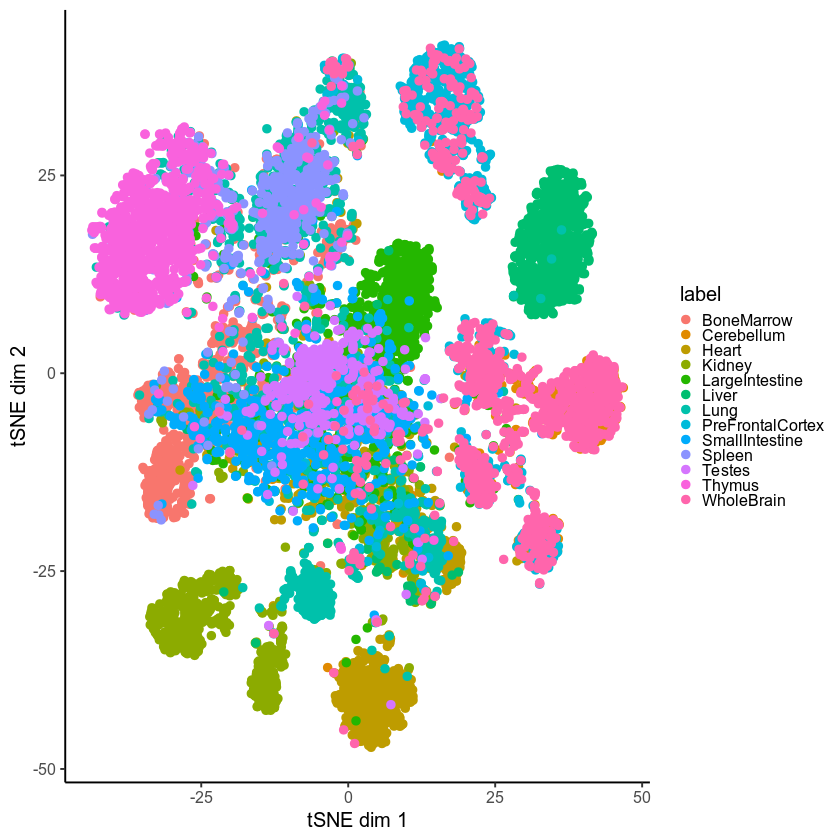

In [58]:
tsne_plots <- plotDeviationsTsne(dev, tsne_results, 
                                 sample_column = "label", 
                                 shiny = FALSE)
tsne_plots[[1]]

In [59]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data/pinello/SHARED_SOFTWARE/anaconda3/envs/ATACseq_chromVAR/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] BSgenome.Mmusculus.UCSC.mm9_1.4.0 BSgenome_1.50.0                  
 [3] rtracklayer_1.42.1                Biostrings_2.50.2                
 [5] XVector_0.22.0                    JASPAR2016_1.10.0                
 [7] SummarizedExperiment_1.12.0 

In [60]:
save.image(file = 'chromVAR_cusanovich2018subset_kmers.RData')